1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2. Apply a distortion correction to raw images.

3. Use color transforms, gradients, etc., to create a thresholded binary image.

4. Apply a perspective transform to rectify binary image ("birds-eye view").

5. Detect lane pixels and fit to find the lane boundary.

6. Determine the curvature of the lane and vehicle position with respect to center.

7. Warp the detected lane boundaries back onto the original image.

8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1. Computing camera callibration matrix and distortion coeffiecents (function returns matrix callibration matrix and distortion coefficients)

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

def get_img_points_and_obj_points(calibration_images_folder):
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    imgpoints = []
    objpoints = []

    images = glob.glob(calibration_images_folder)

    for i in images:
        img = mpimg.imread(i)

        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            #print(corners)
            imgpoints.append(corners)
            objpoints.append(objp)
            #print(objp.shape)
            #print(corners.shape)
           
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
        
    return imgpoints, objpoints, gray.shape[::-1]

def calibrate_camera(calibration_images_folder):
        imgpoints, objpoints, img_shape = get_img_points_and_obj_points(calibration_images_folder)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, img_shape, None, None)
        return mtx, dist

mtx, dist = calibrate_camera('camera_cal/calibration*.jpg')


# 2. Apply A Distortion to Raw Images

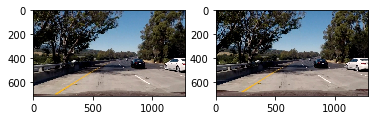

In [134]:
images = glob.glob('test_images/test*.jpg')
num_images = len(images)

test_image = 'test_images/test5.jpg'

undistorted = cv2.undistort(mpimg.imread(test_image),mtx, dist, None, mtx)
#cv2.imwrite('output_images/distortion_correction.jpg',undistorted)
plt.subplot(1,2,1)
plt.imshow(undistorted)
#cv2.imwrite('undistorted_image.jpg',undistorted)
plt.subplot(1,2,2)
plt.imshow(mpimg.imread(test_image))


# 3. Create a Threshold Binary Image

In [135]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


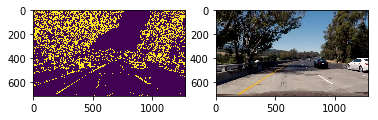

In [168]:
def create_thresholded_binary_image(img, sobel_thresh_min=10, sobel_thresh_max=40, s_thresh_min=200,s_thresh_max=255):
    # get s channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # get grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # get derivatives in x direction for grayscale image
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # create binary based on gradient thresholds
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh_min) & (scaled_sobel <= sobel_thresh_max)] = 1
    
    # create binary based on s channel thresholds
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    color_binary = np.dstack((np.zeros_like(s_binary),s_binary,sobel_binary)) * 255
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    #lower_half_combined_binary = combined_binary[int((combined_binary.shape[0])/2):, :]
    
    #vertices = np.array([[(imshape[1]*0.6/3,imshape[0]),((imshape[1]*1)/3, (imshape[0]*1.25)/2), ((imshape[1]*2)/3, (imshape[0]*1.25)/2), ((imshape[1]*2.4)/3,imshape[0])]],dtype=np.int32) 
    #cropped_binary = region_of_interest(combined_binary,vertices)
    
    return combined_binary

i = create_thresholded_binary_image(undistorted)
#imshape = undistorted.shape
#vertices = np.array([[(imshape[1]*0.5/3,imshape[0]),((imshape[1]*1)/3, (imshape[0]*1.1)/2), ((imshape[1]*2)/3, (imshape[0]*1.1)/2), ((imshape[1]*2.5)/3,imshape[0])]],dtype=np.int32) 
#j = region_of_interest(i,vertices)
plt.subplot(1,2,1)
plt.imshow(i)
plt.subplot(1,2,2)
plt.imshow(undistorted)
#cv2.imwrite('thresholded_image.jpg',i)

# 4. Apply Perspective Transform

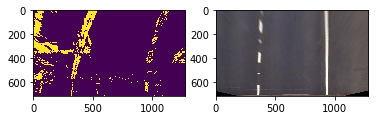

In [169]:
img = mpimg.imread("test_images/straight_lines2.jpg") 
imshape = img.shape
img_size = (img.shape[1],img.shape[0])

src = np.float32([[690, 450],[1042,675],[275,675],[590,450]])
dst = np.float32([[img_size[0]-350,10],[img_size[0]-350,(img_size[1]-10)], [350,img_size[1]-10], [350,10]])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

warped_image = cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
warped_binary = cv2.warpPerspective(i,M,img_size, flags=cv2.INTER_LINEAR)
#vertices = np.array([[(imshape[1]*0.4/3,imshape[0]),((imshape[1]*0.4)/3, 0), ((imshape[1]*2.6)/3, 0), ((imshape[1]*2.6)/3,imshape[0])]],dtype=np.int32) 
#cropped_binary = region_of_interest(warped_binary,vertices)

plt.subplot(1,2,1)
plt.imshow(warped_binary)
plt.subplot(1,2,2)
plt.imshow(warped_image)
#cv2.imwrite('warped_image.jpg',warped_image)

In [170]:
def apply_perspective_transform(image,final_image_size,transformation_matrix):
    imshape = image.shape
    img_size = (imshape[1],imshape[0])
    birds_eye_image = cv2.warpPerspective(image, transformation_matrix, final_image_size,flags=cv2.INTER_LINEAR)
    vertices = np.array([[(imshape[1]*0.4/3,imshape[0]),((imshape[1]*0.4)/3, 0), ((imshape[1]*2.6)/3, 0), ((imshape[1]*2.6)/3,imshape[0])]],dtype=np.int32) 
    cropped_birds_eye_image = region_of_interest(birds_eye_image,vertices)
    return cropped_birds_eye_image


# 5 Detect lane pixels and draw lane boundaries

49
958


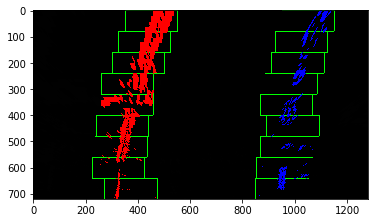

In [171]:
left_window_start = None
right_window_start = None
window_left_start = 374
window_right_start =  950
def draw_lane_boundaries(binary_image):
    histogram = np.sum(binary_image,0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base)
    print(rightx_base)

    out_img = np.dstack((binary_image,binary_image,binary_image))

   
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_image.shape[0]//nwindows)
    nonzero = binary_image.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])


    leftx_current = window_left_start
    rightx_current = window_right_start

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_image.shape[0] - (window+1)*window_height
        win_y_high = binary_image.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0),2)
    
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                     (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #except ValueError:
    #    pass


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx)
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty, rightx,2)

    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[lefty, leftx] = [255,0,0]
    out_img[righty,rightx] = [0,0,255]

    return ploty, left_fitx, right_fitx, out_img, left_fit, right_fit

p, lf, rf, a, b, c = draw_lane_boundaries(warped_binary)
#plt.plot(lf,p,color='red')
#plt.plot(rf,p,color='red')
plt.imshow(a)
#cv2.imwrite('lane_identification.jpg',a)
#plt.imshow(warped_binary)

# 6. Determine the curvature of the lane and vehicle position with respect to center

In [183]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

def find_lane_curvature(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def find_car_position(ploty,left_fit,right_fit,image):
    #max_y = np.argmax(ploty)
    max_y = len(ploty) - 1
    left_point = left_fit[max_y]
    right_point = right_fit[max_y]
    mid_point = (right_point + left_point) // 2
    image_center = image.shape[1]//2
    return (image_center - mid_point) * xm_per_pix


a,b = find_lane_curvature(p, lf, rf)
mid_point = find_car_position(p,lf,rf, warped_image)
print(mid_point)

-0.037


# 7. Warp the detected lane boundaries back onto the original image.

In [220]:
def draw_lanes_on_original_image(left_lane_xs,right_lane_xs,y_axis,birds_eye_image,original_image):
    #left_lane_points = list(zip(left_lane_xs,y_axis))
    #left_lane_points = [np.array([[i,j] for i,j in left_lane_points], np.int32)]
    #right_lane_points = list(zip(right_lane_xs,y_axis))
    #right_lane_points = [np.array([[i,j] for i,j in right_lane_points], np.int32 )]
    
    warp_zero = np.zeros_like(birds_eye_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane_xs, y_axis]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane_xs, y_axis])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #birds_eye_zeros = np.zeros_like(birds_eye_image)
    #three_d_birds_eye_zeros = np.zeros_like(original_image)

    #cv2.polylines(birds_eye_zeros,left_lane_points,False,(255,0,0),thickness=20)
    #cv2.polylines(birds_eye_zeros, right_lane_points, False, (255,0,0),thickness=20)
    #three_d_birds_eye_zeros[:,:,0] = birds_eye_zeros
    lanes_in_original_perspective = apply_perspective_transform(color_warp,
                                                               (original_image.shape[1],original_image.shape[0]),
                                                                Minv)
    #cv2.addWeighted(warped3,0.9,final_warp_zeros,0.5,0)
    image_with_lanes = cv2.addWeighted(original_image,1,lanes_in_original_perspective,0.3,0)
    return image_with_lanes





# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

436
958


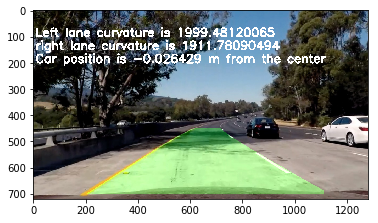

In [221]:
#1. Undistort image
image = mpimg.imread('test_images/test5.jpg')
def process_image(image):
    undistorted_image = cv2.undistort(image,mtx, dist, None, mtx)

    undistorted_image_size = (undistorted_image.shape[1],undistorted_image.shape[0])

    undistorted_binary_image = create_thresholded_binary_image(undistorted_image)

    birds_eye_undistorted_binary_image = apply_perspective_transform(undistorted_binary_image,
                                                                    undistorted_image_size,M)

    y_axis, left_lane_x, right_lane_x, raw_output, left_fit, right_fit = draw_lane_boundaries(birds_eye_undistorted_binary_image)

    lanes_on_original_image = draw_lanes_on_original_image(left_lane_x,
                                                           right_lane_x,
                                                           y_axis,
                                                           birds_eye_undistorted_binary_image,
                                                           undistorted_image)

    left_lane_curvature, right_lane_curvature = find_lane_curvature(y_axis,left_fit, right_fit)

    car_position = find_car_position(y_axis,left_lane_x,right_lane_x,undistorted_image)

    left_curvature_text = "Left lane curvature is %s" % (str(left_lane_curvature))
    right_curvature_text = "right lane curvature is %s" % str(right_lane_curvature)

    car_position_text = "Car position is %f m from the center" % car_position
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(lanes_on_original_image,left_curvature_text, (10,100), font, fontScale,fontColor,lineType)
    cv2.putText(lanes_on_original_image,right_curvature_text, (10,150), font, fontScale,fontColor,lineType)
    cv2.putText(lanes_on_original_image,car_position_text, (10,200), font, fontScale,fontColor,lineType)
    
    #cv2.putText(lanes_on_original_image,car_position,(10,10),6,1,)
    #cv2.imwrite('output_images/test1.jpg',lanes_on_original_image)
    #plt.imshow(lanes_on_original_image)
    return lanes_on_original_image

l = process_image(image)
#cv2.imwrite('lanes_on_road.jpg',l)
plt.imshow(l)

In [222]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [223]:
white_output = 'final_video.mp4'

clip = VideoFileClip("../CarND-Advanced-Lane-Lines/project_video.mp4")
processed_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(white_output, audio=False)

392
973
[MoviePy] >>>> Building video final_video.mp4
[MoviePy] Writing video final_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

392
973


  0%|          | 2/1261 [00:00<03:52,  5.41it/s]

392
974
393
978


  0%|          | 4/1261 [00:00<03:54,  5.36it/s]

394
817
395
825


  0%|          | 6/1261 [00:01<03:52,  5.39it/s]

397
754
397
805


  1%|          | 8/1261 [00:01<03:54,  5.35it/s]

398
806
396
818


  1%|          | 10/1261 [00:01<03:50,  5.43it/s]

396
814
396
805


  1%|          | 12/1261 [00:02<03:52,  5.36it/s]

394
814
394
820


  1%|          | 14/1261 [00:02<03:49,  5.43it/s]

395
855
397
786


  1%|▏         | 16/1261 [00:02<03:48,  5.45it/s]

395
786
395
793


  1%|▏         | 18/1261 [00:03<03:44,  5.53it/s]

394
800
393
871


  2%|▏         | 20/1261 [00:03<03:42,  5.57it/s]

393
781
392
796


  2%|▏         | 22/1261 [00:04<03:41,  5.60it/s]

390
843
389
838


  2%|▏         | 24/1261 [00:04<03:44,  5.50it/s]

385
774
386
780


  2%|▏         | 26/1261 [00:04<03:39,  5.62it/s]

385
797
383
964


  2%|▏         | 28/1261 [00:05<03:41,  5.56it/s]

384
865
379
849


  2%|▏         | 30/1261 [00:05<03:41,  5.55it/s]

380
806
379
809


  3%|▎         | 32/1261 [00:05<03:41,  5.55it/s]

380
809
379
824


  3%|▎         | 34/1261 [00:06<03:38,  5.62it/s]

381
736
383
792


  3%|▎         | 36/1261 [00:06<03:46,  5.41it/s]

385
774
385
781


  3%|▎         | 38/1261 [00:06<03:44,  5.45it/s]

388
787
388
776


  3%|▎         | 40/1261 [00:07<03:44,  5.44it/s]

388
741
388
732


  3%|▎         | 42/1261 [00:07<03:41,  5.50it/s]

390
696
391
709


  3%|▎         | 44/1261 [00:08<05:23,  3.77it/s]

389
824


  4%|▎         | 45/1261 [00:08<06:08,  3.30it/s]

389
714


  4%|▎         | 46/1261 [00:09<06:03,  3.35it/s]

390
860


  4%|▎         | 47/1261 [00:09<05:42,  3.54it/s]

388
810


  4%|▍         | 48/1261 [00:09<05:43,  3.53it/s]

388
756


  4%|▍         | 49/1261 [00:09<05:24,  3.74it/s]

387
779


  4%|▍         | 50/1261 [00:10<05:28,  3.69it/s]

387
761


  4%|▍         | 51/1261 [00:10<05:15,  3.84it/s]

388
789


  4%|▍         | 52/1261 [00:10<05:23,  3.74it/s]

389
802


  4%|▍         | 53/1261 [00:10<05:11,  3.87it/s]

389
763


  4%|▍         | 54/1261 [00:11<05:18,  3.79it/s]

388
737


  4%|▍         | 55/1261 [00:11<05:10,  3.88it/s]

388
819


  4%|▍         | 56/1261 [00:11<05:20,  3.77it/s]

387
771


  5%|▍         | 57/1261 [00:11<05:09,  3.90it/s]

387
781


  5%|▍         | 58/1261 [00:12<05:17,  3.79it/s]

386
793


  5%|▍         | 59/1261 [00:12<05:14,  3.83it/s]

388
745


  5%|▍         | 60/1261 [00:12<05:24,  3.70it/s]

387
738


  5%|▍         | 61/1261 [00:12<05:10,  3.86it/s]

386
707


  5%|▍         | 62/1261 [00:13<05:19,  3.75it/s]

387
764


  5%|▍         | 63/1261 [00:13<05:09,  3.87it/s]

385
774


  5%|▌         | 64/1261 [00:13<05:20,  3.74it/s]

386
785


  5%|▌         | 65/1261 [00:14<05:09,  3.86it/s]

388
693


  5%|▌         | 66/1261 [00:14<05:20,  3.73it/s]

381
752


  5%|▌         | 67/1261 [00:14<05:09,  3.85it/s]

380
714


  5%|▌         | 68/1261 [00:14<05:21,  3.71it/s]

378
725


  5%|▌         | 69/1261 [00:15<05:07,  3.88it/s]

377
720


  6%|▌         | 70/1261 [00:15<05:16,  3.76it/s]

375
740


  6%|▌         | 71/1261 [00:15<05:07,  3.87it/s]

375
748


  6%|▌         | 72/1261 [00:15<05:18,  3.73it/s]

374
753


  6%|▌         | 73/1261 [00:16<05:08,  3.85it/s]

374
735


  6%|▌         | 74/1261 [00:16<05:16,  3.74it/s]

374
782


  6%|▌         | 75/1261 [00:16<05:07,  3.86it/s]

372
792


  6%|▌         | 76/1261 [00:16<05:14,  3.77it/s]

373
750


  6%|▌         | 77/1261 [00:17<05:05,  3.88it/s]

371
943


  6%|▌         | 78/1261 [00:17<05:12,  3.78it/s]

370
781


  6%|▋         | 79/1261 [00:17<05:03,  3.89it/s]

369
810


  6%|▋         | 80/1261 [00:17<05:14,  3.75it/s]

347
834


  6%|▋         | 81/1261 [00:18<05:02,  3.91it/s]

367
734


  7%|▋         | 82/1261 [00:18<05:08,  3.82it/s]

366
811


  7%|▋         | 83/1261 [00:18<05:01,  3.91it/s]

365
822


  7%|▋         | 84/1261 [00:19<05:09,  3.80it/s]

363
833


  7%|▋         | 85/1261 [00:19<04:57,  3.96it/s]

357
859


  7%|▋         | 86/1261 [00:19<05:09,  3.80it/s]

356
815


  7%|▋         | 87/1261 [00:19<05:02,  3.89it/s]

360
815


  7%|▋         | 88/1261 [00:20<05:11,  3.77it/s]

360
802


  7%|▋         | 89/1261 [00:20<05:02,  3.88it/s]

361
763


  7%|▋         | 90/1261 [00:20<05:19,  3.67it/s]

365
767


  7%|▋         | 91/1261 [00:20<05:10,  3.77it/s]

363
943


  7%|▋         | 92/1261 [00:21<05:58,  3.26it/s]

364
719


  7%|▋         | 93/1261 [00:21<06:00,  3.24it/s]

369
794


  7%|▋         | 94/1261 [00:21<05:51,  3.32it/s]

370
727


  8%|▊         | 95/1261 [00:22<05:31,  3.52it/s]

371
731


  8%|▊         | 96/1261 [00:22<05:32,  3.51it/s]

369
752


  8%|▊         | 97/1261 [00:22<05:14,  3.70it/s]

371
770


  8%|▊         | 98/1261 [00:22<05:17,  3.66it/s]

369
779


  8%|▊         | 99/1261 [00:23<05:05,  3.80it/s]

370
773


  8%|▊         | 100/1261 [00:23<05:14,  3.69it/s]

369
783


  8%|▊         | 101/1261 [00:23<05:03,  3.82it/s]

371
790


  8%|▊         | 102/1261 [00:23<05:13,  3.69it/s]

372
801


  8%|▊         | 103/1261 [00:24<05:02,  3.82it/s]

372
941


  8%|▊         | 104/1261 [00:24<05:14,  3.68it/s]

373
941


  8%|▊         | 105/1261 [00:24<05:01,  3.83it/s]

372
831


  8%|▊         | 106/1261 [00:25<05:10,  3.72it/s]

372
788


  8%|▊         | 107/1261 [00:25<05:03,  3.81it/s]

372
880


  9%|▊         | 108/1261 [00:25<05:13,  3.68it/s]

374
826


  9%|▊         | 109/1261 [00:25<05:00,  3.83it/s]

374
767


  9%|▊         | 110/1261 [00:26<05:05,  3.77it/s]

375
874


  9%|▉         | 111/1261 [00:26<04:55,  3.90it/s]

378
770


  9%|▉         | 112/1261 [00:26<05:05,  3.76it/s]

374
793


  9%|▉         | 113/1261 [00:26<04:55,  3.89it/s]

376
781


  9%|▉         | 114/1261 [00:27<05:02,  3.79it/s]

377
797


  9%|▉         | 115/1261 [00:27<04:55,  3.88it/s]

381
952


  9%|▉         | 116/1261 [00:27<05:05,  3.75it/s]

380
804


  9%|▉         | 117/1261 [00:27<04:53,  3.90it/s]

381
958


  9%|▉         | 118/1261 [00:28<04:59,  3.81it/s]

381
725


  9%|▉         | 119/1261 [00:28<04:56,  3.86it/s]

382
733


 10%|▉         | 120/1261 [00:28<05:08,  3.70it/s]

385
740


 10%|▉         | 121/1261 [00:28<04:55,  3.86it/s]

385
750


 10%|▉         | 122/1261 [00:29<05:03,  3.75it/s]

387
757


 10%|▉         | 123/1261 [00:29<04:56,  3.83it/s]

387
748


 10%|▉         | 124/1261 [00:29<05:05,  3.72it/s]

388
762


 10%|▉         | 125/1261 [00:29<04:54,  3.86it/s]

389
770


 10%|▉         | 126/1261 [00:30<05:01,  3.77it/s]

388
790


 10%|█         | 127/1261 [00:30<04:52,  3.88it/s]

389
795


 10%|█         | 128/1261 [00:30<05:02,  3.75it/s]

389
809


 10%|█         | 129/1261 [00:31<04:51,  3.88it/s]

395
708


 10%|█         | 130/1261 [00:31<04:58,  3.78it/s]

391
715


 10%|█         | 131/1261 [00:31<04:51,  3.87it/s]

395
715


 10%|█         | 132/1261 [00:31<05:04,  3.71it/s]

394
735


 11%|█         | 133/1261 [00:32<04:55,  3.82it/s]

394
747


 11%|█         | 134/1261 [00:32<05:01,  3.74it/s]

395
748


 11%|█         | 135/1261 [00:32<05:58,  3.14it/s]

396
769


 11%|█         | 136/1261 [00:33<05:36,  3.34it/s]

396
773


 11%|█         | 137/1261 [00:33<05:32,  3.38it/s]

396
783


 11%|█         | 138/1261 [00:33<05:17,  3.54it/s]

394
805


 11%|█         | 139/1261 [00:33<05:17,  3.53it/s]

393
816


 11%|█         | 140/1261 [00:34<05:05,  3.67it/s]

396
827


 11%|█         | 141/1261 [00:34<05:10,  3.61it/s]

392
797


 11%|█▏        | 142/1261 [00:34<04:57,  3.76it/s]

391
804


 11%|█▏        | 143/1261 [00:34<05:04,  3.67it/s]

392
809


 11%|█▏        | 144/1261 [00:35<04:56,  3.77it/s]

391
816


 11%|█▏        | 145/1261 [00:35<05:06,  3.64it/s]

390
792


 12%|█▏        | 146/1261 [00:35<04:55,  3.77it/s]

389
779


 12%|█▏        | 147/1261 [00:36<05:03,  3.67it/s]

389
790


 12%|█▏        | 148/1261 [00:36<04:54,  3.78it/s]

393
772


 12%|█▏        | 149/1261 [00:36<05:02,  3.68it/s]

393
782


 12%|█▏        | 150/1261 [00:36<04:55,  3.76it/s]

392
769


 12%|█▏        | 151/1261 [00:37<05:01,  3.69it/s]

390
751


 12%|█▏        | 152/1261 [00:37<04:54,  3.77it/s]

389
775


 12%|█▏        | 153/1261 [00:37<05:00,  3.69it/s]

391
788


 12%|█▏        | 154/1261 [00:37<04:51,  3.80it/s]

388
740


 12%|█▏        | 155/1261 [00:38<04:57,  3.71it/s]

386
807


 12%|█▏        | 156/1261 [00:38<04:50,  3.80it/s]

387
818


 12%|█▏        | 157/1261 [00:38<04:55,  3.73it/s]

386
823


 13%|█▎        | 158/1261 [00:38<04:47,  3.83it/s]

385
752


 13%|█▎        | 159/1261 [00:39<04:56,  3.72it/s]

383
775


 13%|█▎        | 160/1261 [00:39<04:46,  3.84it/s]

382
776


 13%|█▎        | 161/1261 [00:39<04:51,  3.77it/s]

380
780


 13%|█▎        | 162/1261 [00:39<04:42,  3.88it/s]

380
793


 13%|█▎        | 163/1261 [00:40<04:52,  3.75it/s]

377
804


 13%|█▎        | 164/1261 [00:40<04:47,  3.81it/s]

378
793


 13%|█▎        | 165/1261 [00:40<04:51,  3.75it/s]

380
797


 13%|█▎        | 166/1261 [00:41<04:41,  3.89it/s]

378
695


 13%|█▎        | 167/1261 [00:41<04:51,  3.75it/s]

379
693


 13%|█▎        | 168/1261 [00:41<04:42,  3.87it/s]

377
701


 13%|█▎        | 169/1261 [00:41<04:47,  3.79it/s]

376
727


 13%|█▎        | 170/1261 [00:42<04:40,  3.90it/s]

374
720


 14%|█▎        | 171/1261 [00:42<04:51,  3.74it/s]

374
745


 14%|█▎        | 172/1261 [00:42<04:43,  3.84it/s]

372
734


 14%|█▎        | 173/1261 [00:42<04:48,  3.77it/s]

372
766


 14%|█▍        | 174/1261 [00:43<04:38,  3.90it/s]

372
748


 14%|█▍        | 175/1261 [00:43<04:48,  3.77it/s]

372
700


 14%|█▍        | 176/1261 [00:43<04:42,  3.84it/s]

373
764


 14%|█▍        | 177/1261 [00:43<04:50,  3.74it/s]

370
766


 14%|█▍        | 178/1261 [00:44<04:38,  3.89it/s]

370
954


 14%|█▍        | 179/1261 [00:44<04:48,  3.76it/s]

370
683


 14%|█▍        | 180/1261 [00:44<04:41,  3.83it/s]

369
755


 14%|█▍        | 181/1261 [00:45<04:47,  3.76it/s]

370
699


 14%|█▍        | 182/1261 [00:45<04:39,  3.87it/s]

363
725


 15%|█▍        | 183/1261 [00:45<04:48,  3.74it/s]

368
713


 15%|█▍        | 184/1261 [00:45<04:40,  3.84it/s]

372
738


 15%|█▍        | 185/1261 [00:46<04:49,  3.72it/s]

368
741


 15%|█▍        | 186/1261 [00:46<04:39,  3.84it/s]

376
729


 15%|█▍        | 187/1261 [00:46<04:49,  3.71it/s]

376
756


 15%|█▍        | 188/1261 [00:46<04:42,  3.80it/s]

381
652


 15%|█▍        | 189/1261 [00:47<04:46,  3.74it/s]

381
659


 15%|█▌        | 190/1261 [00:47<04:37,  3.86it/s]

382
657


 15%|█▌        | 191/1261 [00:47<04:47,  3.72it/s]

385
670


 15%|█▌        | 192/1261 [00:47<04:40,  3.81it/s]

384
675


 15%|█▌        | 193/1261 [00:48<04:47,  3.72it/s]

386
690


 15%|█▌        | 194/1261 [00:48<05:37,  3.16it/s]

386
707


 15%|█▌        | 195/1261 [00:48<05:15,  3.38it/s]

386
720


 16%|█▌        | 196/1261 [00:49<05:15,  3.38it/s]

383
736


 16%|█▌        | 197/1261 [00:49<04:58,  3.57it/s]

379
741


 16%|█▌        | 198/1261 [00:49<04:59,  3.55it/s]

376
751


 16%|█▌        | 199/1261 [00:49<04:47,  3.70it/s]

373
773


 16%|█▌        | 200/1261 [00:50<04:53,  3.61it/s]

373
796


 16%|█▌        | 201/1261 [00:50<04:41,  3.76it/s]

371
779


 16%|█▌        | 202/1261 [00:50<04:47,  3.69it/s]

370
810


 16%|█▌        | 203/1261 [00:50<04:38,  3.80it/s]

369
815


 16%|█▌        | 204/1261 [00:51<04:45,  3.70it/s]

368
800


 16%|█▋        | 205/1261 [00:51<04:33,  3.86it/s]

369
699


 16%|█▋        | 206/1261 [00:51<04:43,  3.72it/s]

370
828


 16%|█▋        | 207/1261 [00:52<04:35,  3.83it/s]

375
715


 16%|█▋        | 208/1261 [00:52<04:46,  3.68it/s]

374
717


 17%|█▋        | 209/1261 [00:52<04:35,  3.81it/s]

374
720


 17%|█▋        | 210/1261 [00:52<04:45,  3.69it/s]

373
747


 17%|█▋        | 211/1261 [00:53<04:34,  3.82it/s]

372
755


 17%|█▋        | 212/1261 [00:53<04:44,  3.69it/s]

372
762


 17%|█▋        | 213/1261 [00:53<04:32,  3.84it/s]

374
774


 17%|█▋        | 214/1261 [00:53<04:40,  3.74it/s]

371
751


 17%|█▋        | 215/1261 [00:54<04:32,  3.84it/s]

370
752


 17%|█▋        | 216/1261 [00:54<04:39,  3.74it/s]

369
764


 17%|█▋        | 217/1261 [00:54<04:28,  3.89it/s]

369
772


 17%|█▋        | 218/1261 [00:54<04:37,  3.76it/s]

366
785


 17%|█▋        | 219/1261 [00:55<04:27,  3.89it/s]

368
714


 17%|█▋        | 220/1261 [00:55<04:36,  3.77it/s]

367
715


 18%|█▊        | 221/1261 [00:55<04:26,  3.90it/s]

367
924


 18%|█▊        | 222/1261 [00:56<04:37,  3.74it/s]

367
739


 18%|█▊        | 223/1261 [00:56<04:30,  3.84it/s]

367
740


 18%|█▊        | 224/1261 [00:56<04:38,  3.72it/s]

369
747


 18%|█▊        | 225/1261 [00:56<04:29,  3.85it/s]

369
772


 18%|█▊        | 226/1261 [00:57<04:37,  3.73it/s]

368
774


 18%|█▊        | 227/1261 [00:57<04:32,  3.80it/s]

368
678


 18%|█▊        | 228/1261 [00:57<04:40,  3.68it/s]

369
759


 18%|█▊        | 229/1261 [00:57<04:28,  3.85it/s]

367
691


 18%|█▊        | 230/1261 [00:58<04:36,  3.73it/s]

362
700


 18%|█▊        | 231/1261 [00:58<04:26,  3.87it/s]

362
711


 18%|█▊        | 232/1261 [00:58<04:32,  3.77it/s]

359
717


 18%|█▊        | 233/1261 [00:58<04:23,  3.90it/s]

358
723


 19%|█▊        | 234/1261 [00:59<04:30,  3.80it/s]

357
737


 19%|█▊        | 235/1261 [00:59<04:25,  3.86it/s]

356
746


 19%|█▊        | 236/1261 [00:59<04:36,  3.70it/s]

356
746


 19%|█▉        | 237/1261 [00:59<04:26,  3.85it/s]

354
752


 19%|█▉        | 238/1261 [01:00<04:34,  3.73it/s]

354
765


 19%|█▉        | 239/1261 [01:00<04:26,  3.83it/s]

353
660


 19%|█▉        | 240/1261 [01:00<04:38,  3.67it/s]

352
669


 19%|█▉        | 241/1261 [01:01<04:25,  3.84it/s]

352
686


 19%|█▉        | 242/1261 [01:01<04:33,  3.72it/s]

349
693


 19%|█▉        | 243/1261 [01:01<04:24,  3.84it/s]

350
701


 19%|█▉        | 244/1261 [01:01<04:31,  3.74it/s]

348
705


 19%|█▉        | 245/1261 [01:02<04:24,  3.84it/s]

348
709


 20%|█▉        | 246/1261 [01:02<04:32,  3.72it/s]

347
722


 20%|█▉        | 247/1261 [01:02<04:23,  3.85it/s]

346
736


 20%|█▉        | 248/1261 [01:02<04:33,  3.71it/s]

347
642


 20%|█▉        | 249/1261 [01:03<04:22,  3.86it/s]

346
704


 20%|█▉        | 250/1261 [01:03<04:31,  3.73it/s]

347
660


 20%|█▉        | 251/1261 [01:03<04:23,  3.83it/s]

346
671


 20%|█▉        | 252/1261 [01:03<04:33,  3.68it/s]

346
670


 20%|██        | 253/1261 [01:04<04:24,  3.82it/s]

347
692


 20%|██        | 254/1261 [01:04<04:30,  3.72it/s]

346
701


 20%|██        | 255/1261 [01:04<04:21,  3.85it/s]

347
701


 20%|██        | 256/1261 [01:05<04:29,  3.73it/s]

347
722


 20%|██        | 257/1261 [01:05<04:22,  3.83it/s]

347
723


 20%|██        | 258/1261 [01:05<04:29,  3.72it/s]

349
740


 21%|██        | 259/1261 [01:05<04:20,  3.84it/s]

349
697


 21%|██        | 260/1261 [01:06<04:32,  3.67it/s]

352
669


 21%|██        | 261/1261 [01:06<04:22,  3.81it/s]

351
779


 21%|██        | 262/1261 [01:06<04:33,  3.65it/s]

352
789


 21%|██        | 263/1261 [01:06<04:26,  3.74it/s]

352
733


 21%|██        | 264/1261 [01:07<04:37,  3.59it/s]

351
743


 21%|██        | 265/1261 [01:07<04:30,  3.68it/s]

350
751


 21%|██        | 266/1261 [01:07<04:42,  3.52it/s]

349
736


 21%|██        | 267/1261 [01:08<04:36,  3.60it/s]

350
807


 21%|██▏       | 268/1261 [01:08<04:47,  3.46it/s]

349
753


 21%|██▏       | 269/1261 [01:08<04:38,  3.57it/s]

348
778


 21%|██▏       | 270/1261 [01:08<04:47,  3.45it/s]

348
805


 21%|██▏       | 271/1261 [01:09<04:38,  3.56it/s]

350
796


 22%|██▏       | 272/1261 [01:09<04:50,  3.40it/s]

354
791


 22%|██▏       | 273/1261 [01:09<04:36,  3.57it/s]

355
789


 22%|██▏       | 274/1261 [01:10<04:44,  3.47it/s]

358
745


 22%|██▏       | 275/1261 [01:10<04:36,  3.57it/s]

358
757


 22%|██▏       | 276/1261 [01:10<04:45,  3.45it/s]

357
785


 22%|██▏       | 277/1261 [01:10<04:33,  3.59it/s]

358
808


 22%|██▏       | 278/1261 [01:11<04:37,  3.54it/s]

357
791


 22%|██▏       | 279/1261 [01:11<04:28,  3.66it/s]

360
764


 22%|██▏       | 280/1261 [01:11<04:35,  3.55it/s]

361
749


 22%|██▏       | 281/1261 [01:11<04:27,  3.67it/s]

362
793


 22%|██▏       | 282/1261 [01:12<04:38,  3.52it/s]

364
797


 22%|██▏       | 283/1261 [01:12<04:34,  3.56it/s]

364
802


 23%|██▎       | 284/1261 [01:12<04:42,  3.46it/s]

366
795


 23%|██▎       | 285/1261 [01:13<04:32,  3.58it/s]

366
806


 23%|██▎       | 286/1261 [01:13<04:39,  3.49it/s]

365
815


 23%|██▎       | 287/1261 [01:13<04:30,  3.61it/s]

366
827


 23%|██▎       | 288/1261 [01:13<04:39,  3.48it/s]

366
831


 23%|██▎       | 289/1261 [01:14<04:32,  3.56it/s]

373
837


 23%|██▎       | 290/1261 [01:14<04:40,  3.46it/s]

372
863


 23%|██▎       | 291/1261 [01:14<04:31,  3.57it/s]

373
831


 23%|██▎       | 292/1261 [01:15<04:30,  3.59it/s]

375
910


 23%|██▎       | 293/1261 [01:15<04:25,  3.64it/s]

375
938


 23%|██▎       | 294/1261 [01:15<04:23,  3.67it/s]

379
805


 23%|██▎       | 295/1261 [01:15<04:13,  3.81it/s]

377
820


 23%|██▎       | 296/1261 [01:16<04:24,  3.65it/s]

378
824


 24%|██▎       | 297/1261 [01:16<04:17,  3.74it/s]

376
825


 24%|██▎       | 298/1261 [01:16<04:29,  3.58it/s]

375
827


 24%|██▎       | 299/1261 [01:16<04:24,  3.64it/s]

374
836


 24%|██▍       | 300/1261 [01:17<04:37,  3.47it/s]

372
844


 24%|██▍       | 301/1261 [01:17<04:22,  3.65it/s]

373
849


 24%|██▍       | 302/1261 [01:17<04:29,  3.56it/s]

370
860


 24%|██▍       | 303/1261 [01:18<04:19,  3.69it/s]

369
863


 24%|██▍       | 304/1261 [01:18<04:27,  3.58it/s]

369
866


 24%|██▍       | 305/1261 [01:18<04:18,  3.70it/s]

368
877


 24%|██▍       | 306/1261 [01:18<04:21,  3.65it/s]

373
871


 24%|██▍       | 307/1261 [01:19<04:12,  3.77it/s]

373
886


 24%|██▍       | 308/1261 [01:19<04:20,  3.66it/s]

375
878


 25%|██▍       | 309/1261 [01:19<04:10,  3.80it/s]

375
869


 25%|██▍       | 310/1261 [01:19<04:17,  3.69it/s]

379
853


 25%|██▍       | 311/1261 [01:20<04:10,  3.79it/s]

386
859


 25%|██▍       | 312/1261 [01:20<04:19,  3.66it/s]

384
864


 25%|██▍       | 313/1261 [01:20<04:10,  3.78it/s]

394
860


 25%|██▍       | 314/1261 [01:21<04:19,  3.65it/s]

394
870


 25%|██▍       | 315/1261 [01:21<04:17,  3.67it/s]

394
877


 25%|██▌       | 316/1261 [01:21<05:08,  3.07it/s]

395
887


 25%|██▌       | 317/1261 [01:22<05:29,  2.86it/s]

394
895


 25%|██▌       | 318/1261 [01:22<05:56,  2.65it/s]

398
874


 25%|██▌       | 319/1261 [01:22<05:16,  2.97it/s]

398
898


 25%|██▌       | 320/1261 [01:23<05:02,  3.11it/s]

395
878


 25%|██▌       | 321/1261 [01:23<04:38,  3.38it/s]

393
888


 26%|██▌       | 322/1261 [01:23<04:32,  3.45it/s]

393
893


 26%|██▌       | 323/1261 [01:23<04:19,  3.62it/s]

394
895


 26%|██▌       | 324/1261 [01:24<04:19,  3.60it/s]

388
908


 26%|██▌       | 325/1261 [01:24<04:10,  3.74it/s]

391
905


 26%|██▌       | 326/1261 [01:24<04:16,  3.64it/s]

392
908


 26%|██▌       | 327/1261 [01:24<04:06,  3.78it/s]

391
917


 26%|██▌       | 328/1261 [01:25<04:13,  3.68it/s]

390
918


 26%|██▌       | 329/1261 [01:25<04:05,  3.80it/s]

379
935


 26%|██▌       | 330/1261 [01:25<04:13,  3.68it/s]

388
906


 26%|██▌       | 331/1261 [01:26<04:05,  3.80it/s]

388
906


 26%|██▋       | 332/1261 [01:26<04:13,  3.66it/s]

395
893


 26%|██▋       | 333/1261 [01:26<04:07,  3.75it/s]

394
894


 26%|██▋       | 334/1261 [01:26<04:12,  3.68it/s]

395
902


 27%|██▋       | 335/1261 [01:27<04:04,  3.79it/s]

394
905


 27%|██▋       | 336/1261 [01:27<04:10,  3.69it/s]

398
918


 27%|██▋       | 337/1261 [01:27<04:03,  3.79it/s]

398
922


 27%|██▋       | 338/1261 [01:27<04:10,  3.69it/s]

398
925


 27%|██▋       | 339/1261 [01:28<04:01,  3.82it/s]

398
945


 27%|██▋       | 340/1261 [01:28<04:10,  3.68it/s]

405
924


 27%|██▋       | 341/1261 [01:28<04:01,  3.81it/s]

402
926


 27%|██▋       | 342/1261 [01:29<04:11,  3.65it/s]

410
919


 27%|██▋       | 343/1261 [01:29<04:02,  3.78it/s]

406
927


 27%|██▋       | 344/1261 [01:29<04:09,  3.68it/s]

402
910


 27%|██▋       | 345/1261 [01:29<03:59,  3.83it/s]

398
936


 27%|██▋       | 346/1261 [01:30<04:04,  3.75it/s]

392
921


 28%|██▊       | 347/1261 [01:30<03:57,  3.85it/s]

394
942


 28%|██▊       | 348/1261 [01:30<04:04,  3.73it/s]

390
926


 28%|██▊       | 349/1261 [01:30<03:56,  3.85it/s]

392
924


 28%|██▊       | 350/1261 [01:31<04:02,  3.76it/s]

388
948


 28%|██▊       | 351/1261 [01:31<03:54,  3.87it/s]

390
932


 28%|██▊       | 352/1261 [01:31<04:03,  3.73it/s]

389
937


 28%|██▊       | 353/1261 [01:31<03:55,  3.85it/s]

383
954


 28%|██▊       | 354/1261 [01:32<03:59,  3.78it/s]

385
953


 28%|██▊       | 355/1261 [01:32<03:53,  3.89it/s]

383
955


 28%|██▊       | 356/1261 [01:32<04:04,  3.70it/s]

383
923


 28%|██▊       | 357/1261 [01:32<03:57,  3.81it/s]

386
919


 28%|██▊       | 358/1261 [01:33<04:07,  3.65it/s]

400
925


 28%|██▊       | 359/1261 [01:33<04:03,  3.71it/s]

407
922


 29%|██▊       | 360/1261 [01:33<04:12,  3.57it/s]

402
926


 29%|██▊       | 361/1261 [01:34<04:02,  3.72it/s]

404
931


 29%|██▊       | 362/1261 [01:34<04:09,  3.61it/s]

401
930


 29%|██▉       | 363/1261 [01:34<03:59,  3.74it/s]

398
953


 29%|██▉       | 364/1261 [01:34<04:04,  3.67it/s]

403
903


 29%|██▉       | 365/1261 [01:35<03:57,  3.77it/s]

401
910


 29%|██▉       | 366/1261 [01:35<04:06,  3.63it/s]

402
932


 29%|██▉       | 367/1261 [01:35<03:59,  3.73it/s]

397
935


 29%|██▉       | 368/1261 [01:35<04:07,  3.61it/s]

397
940


 29%|██▉       | 369/1261 [01:36<03:56,  3.76it/s]

398
919


 29%|██▉       | 370/1261 [01:36<04:03,  3.66it/s]

396
958


 29%|██▉       | 371/1261 [01:36<03:55,  3.78it/s]

396
940


 30%|██▉       | 372/1261 [01:37<04:05,  3.62it/s]

393
966


 30%|██▉       | 373/1261 [01:37<03:55,  3.77it/s]

390
951


 30%|██▉       | 374/1261 [01:37<04:03,  3.64it/s]

390
929


 30%|██▉       | 375/1261 [01:37<03:55,  3.77it/s]

389
944


 30%|██▉       | 376/1261 [01:38<04:03,  3.64it/s]

447
923


 30%|██▉       | 377/1261 [01:38<03:53,  3.78it/s]

388
928


 30%|██▉       | 378/1261 [01:38<04:00,  3.67it/s]

410
906


 30%|███       | 379/1261 [01:38<03:52,  3.79it/s]

404
932


 30%|███       | 380/1261 [01:39<04:01,  3.65it/s]

413
937


 30%|███       | 381/1261 [01:39<03:51,  3.79it/s]

411
942


 30%|███       | 382/1261 [01:39<03:59,  3.67it/s]

408
944


 30%|███       | 383/1261 [01:39<03:53,  3.76it/s]

408
942


 30%|███       | 384/1261 [01:40<04:02,  3.62it/s]

393
942


 31%|███       | 385/1261 [01:40<03:55,  3.72it/s]

403
944


 31%|███       | 386/1261 [01:40<04:01,  3.63it/s]

399
947


 31%|███       | 387/1261 [01:41<03:53,  3.74it/s]

391
951


 31%|███       | 388/1261 [01:41<04:02,  3.61it/s]

393
952


 31%|███       | 389/1261 [01:41<03:53,  3.74it/s]

387
953


 31%|███       | 390/1261 [01:41<04:02,  3.59it/s]

382
955


 31%|███       | 391/1261 [01:42<03:53,  3.72it/s]

380
940


 31%|███       | 392/1261 [01:42<04:02,  3.59it/s]

376
942


 31%|███       | 393/1261 [01:42<03:52,  3.73it/s]

400
955


 31%|███       | 394/1261 [01:43<03:59,  3.62it/s]

395
941


 31%|███▏      | 395/1261 [01:43<03:52,  3.73it/s]

392
952


 31%|███▏      | 396/1261 [01:43<04:00,  3.60it/s]

391
941


 31%|███▏      | 397/1261 [01:43<03:50,  3.76it/s]

385
944


 32%|███▏      | 398/1261 [01:44<03:57,  3.63it/s]

385
945


 32%|███▏      | 399/1261 [01:44<03:50,  3.74it/s]

383
947


 32%|███▏      | 400/1261 [01:44<03:56,  3.64it/s]

384
948


 32%|███▏      | 401/1261 [01:44<03:49,  3.75it/s]

382
950


 32%|███▏      | 402/1261 [01:45<03:58,  3.60it/s]

383
947


 32%|███▏      | 403/1261 [01:45<03:48,  3.75it/s]

385
944


 32%|███▏      | 404/1261 [01:45<03:54,  3.65it/s]

380
947


 32%|███▏      | 405/1261 [01:45<03:44,  3.81it/s]

384
952


 32%|███▏      | 406/1261 [01:46<03:50,  3.72it/s]

380
938


 32%|███▏      | 407/1261 [01:46<03:43,  3.82it/s]

378
958


 32%|███▏      | 408/1261 [01:46<03:50,  3.69it/s]

378
938


 32%|███▏      | 409/1261 [01:47<03:41,  3.84it/s]

377
957


 33%|███▎      | 410/1261 [01:47<03:48,  3.72it/s]

378
938


 33%|███▎      | 411/1261 [01:47<03:41,  3.84it/s]

377
939


 33%|███▎      | 412/1261 [01:47<03:46,  3.74it/s]

377
938


 33%|███▎      | 413/1261 [01:48<03:39,  3.86it/s]

376
938


 33%|███▎      | 414/1261 [01:48<03:48,  3.70it/s]

375
924


 33%|███▎      | 415/1261 [01:48<03:41,  3.81it/s]

364
939


 33%|███▎      | 416/1261 [01:48<03:48,  3.70it/s]

376
928


 33%|███▎      | 417/1261 [01:49<03:39,  3.85it/s]

378
925


 33%|███▎      | 418/1261 [01:49<03:47,  3.71it/s]

376
946


 33%|███▎      | 419/1261 [01:49<03:41,  3.80it/s]

373
930


 33%|███▎      | 420/1261 [01:49<03:50,  3.65it/s]

377
930


 33%|███▎      | 421/1261 [01:50<03:42,  3.77it/s]

376
931


 33%|███▎      | 422/1261 [01:50<03:50,  3.64it/s]

362
929


 34%|███▎      | 423/1261 [01:50<03:41,  3.79it/s]

376
927


 34%|███▎      | 424/1261 [01:51<03:49,  3.65it/s]

374
929


 34%|███▎      | 425/1261 [01:51<03:40,  3.79it/s]

372
930


 34%|███▍      | 426/1261 [01:51<03:47,  3.68it/s]

366
934


 34%|███▍      | 427/1261 [01:51<03:38,  3.81it/s]

366
937


 34%|███▍      | 428/1261 [01:52<03:47,  3.67it/s]

366
937


 34%|███▍      | 429/1261 [01:52<03:37,  3.82it/s]

369
932


 34%|███▍      | 430/1261 [01:52<03:47,  3.64it/s]

369
933


 34%|███▍      | 431/1261 [01:52<03:41,  3.75it/s]

364
940


 34%|███▍      | 432/1261 [01:53<03:50,  3.60it/s]

364
925


 34%|███▍      | 433/1261 [01:53<03:40,  3.75it/s]

361
934


 34%|███▍      | 434/1261 [01:53<03:46,  3.65it/s]

362
933


 34%|███▍      | 435/1261 [01:53<03:37,  3.79it/s]

362
933


 35%|███▍      | 436/1261 [01:54<03:45,  3.66it/s]

361
932


 35%|███▍      | 437/1261 [01:54<03:38,  3.78it/s]

363
894


 35%|███▍      | 438/1261 [01:54<03:42,  3.70it/s]

361
929


 35%|███▍      | 439/1261 [01:55<03:34,  3.83it/s]

363
913


 35%|███▍      | 440/1261 [01:55<03:43,  3.68it/s]

366
924


 35%|███▍      | 441/1261 [01:55<03:34,  3.83it/s]

364
895


 35%|███▌      | 442/1261 [01:55<03:38,  3.74it/s]

362
896


 35%|███▌      | 443/1261 [01:56<03:32,  3.85it/s]

358
919


 35%|███▌      | 444/1261 [01:56<03:42,  3.68it/s]

358
907


 35%|███▌      | 445/1261 [01:56<03:34,  3.81it/s]

355
931


 35%|███▌      | 446/1261 [01:56<03:39,  3.72it/s]

355
916


 35%|███▌      | 447/1261 [01:57<03:31,  3.84it/s]

355
906


 36%|███▌      | 448/1261 [01:57<03:41,  3.67it/s]

355
909


 36%|███▌      | 449/1261 [01:57<03:33,  3.81it/s]

354
910


 36%|███▌      | 450/1261 [01:58<03:41,  3.67it/s]

366
912


 36%|███▌      | 451/1261 [01:58<03:31,  3.82it/s]

352
912


 36%|███▌      | 452/1261 [01:58<03:38,  3.71it/s]

367
915


 36%|███▌      | 453/1261 [01:58<03:29,  3.85it/s]

364
929


 36%|███▌      | 454/1261 [01:59<03:34,  3.76it/s]

377
918


 36%|███▌      | 455/1261 [01:59<03:28,  3.86it/s]

377
920


 36%|███▌      | 456/1261 [01:59<03:37,  3.70it/s]

376
922


 36%|███▌      | 457/1261 [01:59<03:28,  3.85it/s]

379
908


 36%|███▋      | 458/1261 [02:00<03:37,  3.69it/s]

378
908


 36%|███▋      | 459/1261 [02:00<03:30,  3.81it/s]

384
905


 36%|███▋      | 460/1261 [02:00<03:36,  3.70it/s]

381
911


 37%|███▋      | 461/1261 [02:00<03:28,  3.85it/s]

378
912


 37%|███▋      | 462/1261 [02:01<03:38,  3.66it/s]

373
917


 37%|███▋      | 463/1261 [02:01<03:31,  3.76it/s]

366
933


 37%|███▋      | 464/1261 [02:01<03:37,  3.67it/s]

373
919


 37%|███▋      | 465/1261 [02:01<03:29,  3.81it/s]

371
924


 37%|███▋      | 466/1261 [02:02<03:34,  3.70it/s]

372
921


 37%|███▋      | 467/1261 [02:02<03:29,  3.79it/s]

369
923


 37%|███▋      | 468/1261 [02:02<03:35,  3.68it/s]

369
924


 37%|███▋      | 469/1261 [02:03<03:26,  3.83it/s]

368
923


 37%|███▋      | 470/1261 [02:03<03:33,  3.70it/s]

360
932


 37%|███▋      | 471/1261 [02:03<03:26,  3.83it/s]

362
926


 37%|███▋      | 472/1261 [02:03<03:31,  3.73it/s]

362
926


 38%|███▊      | 473/1261 [02:04<03:24,  3.85it/s]

373
928


 38%|███▊      | 474/1261 [02:04<03:30,  3.75it/s]

377
925


 38%|███▊      | 475/1261 [02:04<03:25,  3.83it/s]

368
935


 38%|███▊      | 476/1261 [02:04<03:34,  3.66it/s]

366
936


 38%|███▊      | 477/1261 [02:05<03:27,  3.78it/s]

363
939


 38%|███▊      | 478/1261 [02:05<03:39,  3.57it/s]

363
942


 38%|███▊      | 479/1261 [02:05<03:34,  3.65it/s]

362
924


 38%|███▊      | 480/1261 [02:06<03:42,  3.51it/s]

365
928


 38%|███▊      | 481/1261 [02:06<03:33,  3.65it/s]

363
946


 38%|███▊      | 482/1261 [02:06<03:45,  3.46it/s]

363
930


 38%|███▊      | 483/1261 [02:06<03:38,  3.57it/s]

361
931


 38%|███▊      | 484/1261 [02:07<03:47,  3.42it/s]

358
929


 38%|███▊      | 485/1261 [02:07<03:40,  3.52it/s]

355
929


 39%|███▊      | 486/1261 [02:07<03:44,  3.45it/s]

361
945


 39%|███▊      | 487/1261 [02:08<03:37,  3.56it/s]

362
944


 39%|███▊      | 488/1261 [02:08<03:42,  3.47it/s]

362
939


 39%|███▉      | 489/1261 [02:08<03:34,  3.59it/s]

366
937


 39%|███▉      | 490/1261 [02:08<03:40,  3.50it/s]

369
937


 39%|███▉      | 491/1261 [02:09<03:33,  3.61it/s]

370
937


 39%|███▉      | 492/1261 [02:09<03:44,  3.42it/s]

367
940


 39%|███▉      | 493/1261 [02:09<03:35,  3.57it/s]

375
942


 39%|███▉      | 494/1261 [02:10<03:41,  3.47it/s]

364
945


 39%|███▉      | 495/1261 [02:10<03:33,  3.59it/s]

363
944


 39%|███▉      | 496/1261 [02:10<03:38,  3.51it/s]

366
926


 39%|███▉      | 497/1261 [02:10<03:27,  3.68it/s]

363
942


 39%|███▉      | 498/1261 [02:11<03:30,  3.63it/s]

366
925


 40%|███▉      | 499/1261 [02:11<03:20,  3.79it/s]

362
928


 40%|███▉      | 500/1261 [02:11<03:27,  3.66it/s]

352
946


 40%|███▉      | 501/1261 [02:11<03:18,  3.83it/s]

346
948


 40%|███▉      | 502/1261 [02:12<03:24,  3.72it/s]

341
957


 40%|███▉      | 503/1261 [02:12<03:18,  3.83it/s]

348
951


 40%|███▉      | 504/1261 [02:12<03:23,  3.71it/s]

346
951


 40%|████      | 505/1261 [02:12<03:15,  3.87it/s]

346
951


 40%|████      | 506/1261 [02:13<03:23,  3.71it/s]

365
952


 40%|████      | 507/1261 [02:13<03:16,  3.84it/s]

362
953


 40%|████      | 508/1261 [02:13<03:23,  3.70it/s]

364
952


 40%|████      | 509/1261 [02:14<03:16,  3.83it/s]

360
952


 40%|████      | 510/1261 [02:14<03:23,  3.70it/s]

363
948


 41%|████      | 511/1261 [02:14<03:16,  3.82it/s]

360
945


 41%|████      | 512/1261 [02:14<03:23,  3.68it/s]

363
942


 41%|████      | 513/1261 [02:15<03:15,  3.82it/s]

361
938


 41%|████      | 514/1261 [02:15<03:20,  3.72it/s]

364
939


 41%|████      | 515/1261 [02:15<03:15,  3.81it/s]

366
939


 41%|████      | 516/1261 [02:15<03:20,  3.71it/s]

362
941


 41%|████      | 517/1261 [02:16<03:14,  3.83it/s]

342
944


 41%|████      | 518/1261 [02:16<03:19,  3.72it/s]

361
943


 41%|████      | 519/1261 [02:16<03:14,  3.82it/s]

361
949


 41%|████      | 520/1261 [02:16<03:20,  3.69it/s]

361
946


 41%|████▏     | 521/1261 [02:17<03:13,  3.82it/s]

364
944


 41%|████▏     | 522/1261 [02:17<03:21,  3.66it/s]

364
944


 41%|████▏     | 523/1261 [02:17<03:15,  3.77it/s]

365
944


 42%|████▏     | 524/1261 [02:18<03:23,  3.62it/s]

358
942


 42%|████▏     | 525/1261 [02:18<03:15,  3.77it/s]

362
941


 42%|████▏     | 526/1261 [02:18<03:20,  3.66it/s]

355
949


 42%|████▏     | 527/1261 [02:18<03:14,  3.76it/s]

354
948


 42%|████▏     | 528/1261 [02:19<03:22,  3.62it/s]

346
956


 42%|████▏     | 529/1261 [02:19<03:13,  3.79it/s]

349
953


 42%|████▏     | 530/1261 [02:19<03:24,  3.58it/s]

357
946


 42%|████▏     | 531/1261 [02:19<03:19,  3.65it/s]

359
945


 42%|████▏     | 532/1261 [02:20<03:26,  3.54it/s]

374
940


 42%|████▏     | 533/1261 [02:20<03:19,  3.66it/s]

374
939


 42%|████▏     | 534/1261 [02:20<03:25,  3.54it/s]

372
937


 42%|████▏     | 535/1261 [02:21<03:18,  3.66it/s]

375
934


 43%|████▎     | 536/1261 [02:21<04:00,  3.01it/s]

370
943


 43%|████▎     | 537/1261 [02:21<04:15,  2.84it/s]

371
944


 43%|████▎     | 538/1261 [02:22<04:38,  2.60it/s]

372
950


 43%|████▎     | 539/1261 [02:22<04:47,  2.52it/s]

373
947


 43%|████▎     | 540/1261 [02:23<05:06,  2.35it/s]

371
950


 43%|████▎     | 541/1261 [02:23<04:28,  2.68it/s]

371
948


 43%|████▎     | 542/1261 [02:23<04:05,  2.93it/s]

372
946


 43%|████▎     | 543/1261 [02:24<03:45,  3.18it/s]

370
949


 43%|████▎     | 544/1261 [02:24<03:34,  3.34it/s]

369
944


 43%|████▎     | 545/1261 [02:24<03:21,  3.55it/s]

367
947


 43%|████▎     | 546/1261 [02:24<03:21,  3.54it/s]

368
947


 43%|████▎     | 547/1261 [02:25<03:15,  3.66it/s]

367
949


 43%|████▎     | 548/1261 [02:25<03:23,  3.50it/s]

371
962


 44%|████▎     | 549/1261 [02:25<03:18,  3.59it/s]

369
959


 44%|████▎     | 550/1261 [02:25<03:25,  3.47it/s]

366
976


 44%|████▎     | 551/1261 [02:26<03:19,  3.56it/s]

365
975


 44%|████▍     | 552/1261 [02:26<03:29,  3.39it/s]

362
980


 44%|████▍     | 553/1261 [02:26<03:20,  3.53it/s]

363
978


 44%|████▍     | 554/1261 [02:27<03:26,  3.42it/s]

358
977


 44%|████▍     | 555/1261 [02:27<03:21,  3.50it/s]

362
974


 44%|████▍     | 556/1261 [02:27<03:27,  3.40it/s]

365
969


 44%|████▍     | 557/1261 [02:27<03:20,  3.51it/s]

364
965


 44%|████▍     | 558/1261 [02:28<03:25,  3.41it/s]

363
968


 44%|████▍     | 559/1261 [02:28<03:20,  3.50it/s]

355
986


 44%|████▍     | 560/1261 [02:28<03:26,  3.39it/s]

339
645


 44%|████▍     | 561/1261 [02:29<03:18,  3.52it/s]

333
690


 45%|████▍     | 562/1261 [02:29<03:23,  3.43it/s]

328
1081


 45%|████▍     | 563/1261 [02:29<03:17,  3.53it/s]

337
1024


 45%|████▍     | 564/1261 [02:30<03:22,  3.44it/s]

349
990


 45%|████▍     | 565/1261 [02:30<03:14,  3.58it/s]

353
978


 45%|████▍     | 566/1261 [02:30<03:20,  3.46it/s]

170
968


 45%|████▍     | 567/1261 [02:30<03:13,  3.58it/s]

171
946


 45%|████▌     | 568/1261 [02:31<03:20,  3.46it/s]

170
945


 45%|████▌     | 569/1261 [02:31<03:14,  3.55it/s]

172
959


 45%|████▌     | 570/1261 [02:31<03:21,  3.43it/s]

361
970


 45%|████▌     | 571/1261 [02:32<03:13,  3.56it/s]

357
969


 45%|████▌     | 572/1261 [02:32<03:20,  3.44it/s]

355
968


 45%|████▌     | 573/1261 [02:32<03:11,  3.59it/s]

356
973


 46%|████▌     | 574/1261 [02:32<03:16,  3.49it/s]

357
988


 46%|████▌     | 575/1261 [02:33<03:12,  3.56it/s]

356
987


 46%|████▌     | 576/1261 [02:33<03:17,  3.46it/s]

358
982


 46%|████▌     | 577/1261 [02:33<03:10,  3.60it/s]

358
972


 46%|████▌     | 578/1261 [02:34<03:17,  3.46it/s]

362
951


 46%|████▌     | 579/1261 [02:34<03:11,  3.56it/s]

363
948


 46%|████▌     | 580/1261 [02:34<03:18,  3.43it/s]

362
965


 46%|████▌     | 581/1261 [02:34<03:11,  3.55it/s]

362
951


 46%|████▌     | 582/1261 [02:35<03:13,  3.51it/s]

359
951
360
950


 46%|████▋     | 584/1261 [02:35<03:36,  3.12it/s]

360
947


 46%|████▋     | 585/1261 [02:36<03:33,  3.17it/s]

352
949


 46%|████▋     | 586/1261 [02:36<03:20,  3.36it/s]

359
954


 47%|████▋     | 587/1261 [02:36<03:24,  3.30it/s]

356
950


 47%|████▋     | 588/1261 [02:37<03:14,  3.47it/s]

357
947


 47%|████▋     | 589/1261 [02:37<03:16,  3.42it/s]

343
951


 47%|████▋     | 590/1261 [02:37<03:10,  3.52it/s]

338
959


 47%|████▋     | 591/1261 [02:37<03:14,  3.45it/s]

400
969


 47%|████▋     | 592/1261 [02:38<03:08,  3.54it/s]

321
959


 47%|████▋     | 593/1261 [02:38<03:15,  3.42it/s]

505
966


 47%|████▋     | 594/1261 [02:38<03:08,  3.54it/s]

393
965


 47%|████▋     | 595/1261 [02:39<03:15,  3.40it/s]

382
958


 47%|████▋     | 596/1261 [02:39<03:11,  3.47it/s]

350
966


 47%|████▋     | 597/1261 [02:39<03:17,  3.36it/s]

346
969


 47%|████▋     | 598/1261 [02:39<03:11,  3.46it/s]

346
967


 48%|████▊     | 599/1261 [02:40<03:25,  3.22it/s]

344
975


 48%|████▊     | 600/1261 [02:40<03:22,  3.27it/s]

343
973


 48%|████▊     | 601/1261 [02:40<03:24,  3.23it/s]

347
977


 48%|████▊     | 602/1261 [02:41<03:16,  3.36it/s]

371
982


 48%|████▊     | 603/1261 [02:41<03:21,  3.26it/s]

338
983


 48%|████▊     | 604/1261 [02:41<03:13,  3.40it/s]

356
972


 48%|████▊     | 605/1261 [02:42<03:15,  3.35it/s]

373
968


 48%|████▊     | 606/1261 [02:42<03:38,  3.00it/s]

391
990


 48%|████▊     | 607/1261 [02:42<03:27,  3.15it/s]

399
981


 48%|████▊     | 608/1261 [02:43<03:32,  3.07it/s]

388
998


 48%|████▊     | 609/1261 [02:43<03:20,  3.26it/s]

381
990


 48%|████▊     | 610/1261 [02:43<03:25,  3.17it/s]

364
987


 48%|████▊     | 611/1261 [02:43<03:17,  3.29it/s]

362
986


 49%|████▊     | 612/1261 [02:44<03:16,  3.30it/s]

388
976


 49%|████▊     | 613/1261 [02:44<03:27,  3.13it/s]

351
1019


 49%|████▊     | 614/1261 [02:44<03:19,  3.25it/s]

369
1020


 49%|████▉     | 615/1261 [02:45<03:25,  3.15it/s]

345
1014


 49%|████▉     | 616/1261 [02:45<03:16,  3.28it/s]

345
1010


 49%|████▉     | 617/1261 [02:45<03:18,  3.24it/s]

343
1006


 49%|████▉     | 618/1261 [02:46<03:09,  3.39it/s]

374
998


 49%|████▉     | 619/1261 [02:46<03:14,  3.29it/s]

373
984


 49%|████▉     | 620/1261 [02:46<03:10,  3.36it/s]

370
989


 49%|████▉     | 621/1261 [02:47<03:17,  3.23it/s]

185
977


 49%|████▉     | 622/1261 [02:47<03:09,  3.37it/s]

363
986


 49%|████▉     | 623/1261 [02:47<03:19,  3.20it/s]

367
1000


 49%|████▉     | 624/1261 [02:47<03:10,  3.35it/s]

509
996


 50%|████▉     | 625/1261 [02:48<03:16,  3.24it/s]

564
1019


 50%|████▉     | 626/1261 [02:48<03:09,  3.36it/s]

454
654


 50%|████▉     | 627/1261 [02:48<03:13,  3.27it/s]

447
654


 50%|████▉     | 628/1261 [02:49<03:05,  3.41it/s]

350
652


 50%|████▉     | 629/1261 [02:49<03:08,  3.35it/s]

345
648


 50%|████▉     | 630/1261 [02:49<03:02,  3.45it/s]

523
640


 50%|█████     | 631/1261 [02:50<03:05,  3.40it/s]

423
670


 50%|█████     | 632/1261 [02:50<02:59,  3.49it/s]

477
1089


 50%|█████     | 633/1261 [02:50<03:03,  3.42it/s]

476
1100


 50%|█████     | 634/1261 [02:50<02:58,  3.52it/s]

475
1045


 50%|█████     | 635/1261 [02:51<03:02,  3.43it/s]

484
1084


 50%|█████     | 636/1261 [02:51<02:56,  3.53it/s]

576
643


 51%|█████     | 637/1261 [02:51<03:00,  3.46it/s]

639
641


 51%|█████     | 638/1261 [02:51<02:55,  3.55it/s]

636
642


 51%|█████     | 639/1261 [02:52<02:59,  3.47it/s]

639
640


 51%|█████     | 640/1261 [02:52<02:54,  3.55it/s]

558
640


 51%|█████     | 641/1261 [02:52<02:58,  3.47it/s]

545
1085


 51%|█████     | 642/1261 [02:53<02:51,  3.61it/s]

418
1083


 51%|█████     | 643/1261 [02:53<02:58,  3.46it/s]

550
1049


 51%|█████     | 644/1261 [02:53<02:52,  3.57it/s]

558
1054


 51%|█████     | 645/1261 [02:53<02:54,  3.53it/s]

574
1038


 51%|█████     | 646/1261 [02:54<02:48,  3.65it/s]

609
648


 51%|█████▏    | 647/1261 [02:54<02:56,  3.47it/s]

543
1094


 51%|█████▏    | 648/1261 [02:54<02:50,  3.59it/s]

573
650


 51%|█████▏    | 649/1261 [02:55<02:53,  3.53it/s]

592
658


 52%|█████▏    | 650/1261 [02:55<02:47,  3.65it/s]

420
650


 52%|█████▏    | 651/1261 [02:55<02:54,  3.49it/s]

581
649


 52%|█████▏    | 652/1261 [02:55<02:49,  3.59it/s]

568
1070


 52%|█████▏    | 653/1261 [02:56<02:54,  3.49it/s]

583
1049


 52%|█████▏    | 654/1261 [02:56<02:48,  3.59it/s]

587
1044


 52%|█████▏    | 655/1261 [02:56<02:54,  3.47it/s]

588
1035


 52%|█████▏    | 656/1261 [02:57<02:50,  3.56it/s]

621
1038


 52%|█████▏    | 657/1261 [02:57<02:54,  3.46it/s]

552
1100


 52%|█████▏    | 658/1261 [02:57<02:49,  3.57it/s]

571
1086


 52%|█████▏    | 659/1261 [02:57<02:53,  3.48it/s]

547
1066


 52%|█████▏    | 660/1261 [02:58<02:48,  3.57it/s]

582
966


 52%|█████▏    | 661/1261 [02:58<02:53,  3.46it/s]

581
1071


 52%|█████▏    | 662/1261 [02:58<02:49,  3.54it/s]

533
1072


 53%|█████▎    | 663/1261 [02:59<02:54,  3.43it/s]

387
1067


 53%|█████▎    | 664/1261 [02:59<02:50,  3.50it/s]

552
1054


 53%|█████▎    | 665/1261 [02:59<02:56,  3.39it/s]

541
1042


 53%|█████▎    | 666/1261 [02:59<02:49,  3.51it/s]

538
1035


 53%|█████▎    | 667/1261 [03:00<02:54,  3.40it/s]

552
1026


 53%|█████▎    | 668/1261 [03:00<02:51,  3.46it/s]

548
1034


 53%|█████▎    | 669/1261 [03:00<02:53,  3.42it/s]

519
1031
200
1026


 53%|█████▎    | 671/1261 [03:01<03:15,  3.02it/s]

562
983


 53%|█████▎    | 672/1261 [03:01<03:02,  3.22it/s]

417
1066


 53%|█████▎    | 673/1261 [03:02<03:04,  3.19it/s]

580
1078


 53%|█████▎    | 674/1261 [03:02<02:55,  3.35it/s]

570
1064


 54%|█████▎    | 675/1261 [03:02<02:55,  3.33it/s]

548
1050


 54%|█████▎    | 676/1261 [03:03<02:48,  3.47it/s]

573
1050


 54%|█████▎    | 677/1261 [03:03<02:53,  3.37it/s]

572
993


 54%|█████▍    | 678/1261 [03:03<02:46,  3.50it/s]

567
1045


 54%|█████▍    | 679/1261 [03:03<02:46,  3.49it/s]

536
1030


 54%|█████▍    | 680/1261 [03:04<02:55,  3.31it/s]

535
1035


 54%|█████▍    | 681/1261 [03:04<02:48,  3.45it/s]

551
1030


 54%|█████▍    | 682/1261 [03:04<02:46,  3.47it/s]

553
1025


 54%|█████▍    | 683/1261 [03:05<02:50,  3.39it/s]

508
1014


 54%|█████▍    | 684/1261 [03:05<02:44,  3.51it/s]

557
967


 54%|█████▍    | 685/1261 [03:05<02:45,  3.47it/s]

552
966


 54%|█████▍    | 686/1261 [03:05<02:38,  3.62it/s]

566
964


 54%|█████▍    | 687/1261 [03:06<02:42,  3.53it/s]

557
956


 55%|█████▍    | 688/1261 [03:06<02:37,  3.64it/s]

560
1044


 55%|█████▍    | 689/1261 [03:06<02:40,  3.55it/s]

542
1055


 55%|█████▍    | 690/1261 [03:06<02:34,  3.70it/s]

189
1045


 55%|█████▍    | 691/1261 [03:07<02:37,  3.63it/s]

416
972


 55%|█████▍    | 692/1261 [03:07<02:31,  3.75it/s]

417
1027


 55%|█████▍    | 693/1261 [03:07<02:34,  3.67it/s]

414
1026


 55%|█████▌    | 694/1261 [03:08<02:27,  3.84it/s]

502
966


 55%|█████▌    | 695/1261 [03:08<02:32,  3.72it/s]

412
1014


 55%|█████▌    | 696/1261 [03:08<02:28,  3.81it/s]

563
1014


 55%|█████▌    | 697/1261 [03:08<02:30,  3.74it/s]

581
1007


 55%|█████▌    | 698/1261 [03:09<02:26,  3.84it/s]

570
975


 55%|█████▌    | 699/1261 [03:09<02:31,  3.72it/s]

561
1048


 56%|█████▌    | 700/1261 [03:09<02:28,  3.77it/s]

584
967


 56%|█████▌    | 701/1261 [03:09<02:31,  3.69it/s]

593
965


 56%|█████▌    | 702/1261 [03:10<02:27,  3.79it/s]

594
965


 56%|█████▌    | 703/1261 [03:10<02:34,  3.61it/s]

594
965


 56%|█████▌    | 704/1261 [03:10<02:28,  3.74it/s]

594
964


 56%|█████▌    | 705/1261 [03:10<02:30,  3.69it/s]

594
959


 56%|█████▌    | 706/1261 [03:11<02:25,  3.82it/s]

579
962


 56%|█████▌    | 707/1261 [03:11<02:30,  3.68it/s]

542
961


 56%|█████▌    | 708/1261 [03:11<02:25,  3.81it/s]

542
959


 56%|█████▌    | 709/1261 [03:12<02:29,  3.70it/s]

591
956


 56%|█████▋    | 710/1261 [03:12<02:24,  3.81it/s]

581
953


 56%|█████▋    | 711/1261 [03:12<02:27,  3.72it/s]

577
954


 56%|█████▋    | 712/1261 [03:12<02:22,  3.84it/s]

563
954


 57%|█████▋    | 713/1261 [03:13<02:25,  3.76it/s]

571
1046


 57%|█████▋    | 714/1261 [03:13<02:21,  3.87it/s]

551
963


 57%|█████▋    | 715/1261 [03:13<02:25,  3.76it/s]

577
1019


 57%|█████▋    | 716/1261 [03:13<02:21,  3.86it/s]

573
641


 57%|█████▋    | 717/1261 [03:14<02:24,  3.77it/s]

534
961


 57%|█████▋    | 718/1261 [03:14<02:20,  3.88it/s]

562
1026


 57%|█████▋    | 719/1261 [03:14<02:24,  3.76it/s]

509
1026


 57%|█████▋    | 720/1261 [03:14<02:20,  3.86it/s]

511
1022


 57%|█████▋    | 721/1261 [03:15<02:23,  3.77it/s]

523
963


 57%|█████▋    | 722/1261 [03:15<02:18,  3.88it/s]

523
1102


 57%|█████▋    | 723/1261 [03:15<02:22,  3.78it/s]

594
964


 57%|█████▋    | 724/1261 [03:15<02:17,  3.89it/s]

583
964


 57%|█████▋    | 725/1261 [03:16<02:21,  3.79it/s]

578
1093


 58%|█████▊    | 726/1261 [03:16<02:16,  3.91it/s]

572
1087


 58%|█████▊    | 727/1261 [03:16<02:20,  3.79it/s]

569
642


 58%|█████▊    | 728/1261 [03:17<02:18,  3.84it/s]

570
982


 58%|█████▊    | 729/1261 [03:17<02:16,  3.91it/s]

540
981


 58%|█████▊    | 730/1261 [03:17<02:22,  3.73it/s]

543
980


 58%|█████▊    | 731/1261 [03:17<02:19,  3.80it/s]

604
643


 58%|█████▊    | 732/1261 [03:18<02:16,  3.87it/s]

579
640


 58%|█████▊    | 733/1261 [03:18<02:23,  3.67it/s]

625
642


 58%|█████▊    | 734/1261 [03:18<02:18,  3.81it/s]

620
642


 58%|█████▊    | 735/1261 [03:18<02:21,  3.72it/s]

615
970


 58%|█████▊    | 736/1261 [03:19<02:16,  3.84it/s]

505
640


 58%|█████▊    | 737/1261 [03:19<02:21,  3.71it/s]

595
640


 59%|█████▊    | 738/1261 [03:19<02:19,  3.75it/s]

437
642


 59%|█████▊    | 739/1261 [03:19<02:18,  3.78it/s]

580
648


 59%|█████▊    | 740/1261 [03:20<02:23,  3.63it/s]

443
642


 59%|█████▉    | 741/1261 [03:20<02:17,  3.79it/s]

545
979


 59%|█████▉    | 742/1261 [03:20<02:20,  3.68it/s]

452
978


 59%|█████▉    | 743/1261 [03:21<02:19,  3.72it/s]

446
650


 59%|█████▉    | 744/1261 [03:21<02:49,  3.06it/s]

599
640


 59%|█████▉    | 745/1261 [03:21<02:58,  2.89it/s]

604
642


 59%|█████▉    | 746/1261 [03:22<03:14,  2.65it/s]

628
642


 59%|█████▉    | 747/1261 [03:22<03:14,  2.64it/s]

618
640


 59%|█████▉    | 748/1261 [03:23<03:25,  2.50it/s]

620
648


 59%|█████▉    | 749/1261 [03:23<03:27,  2.47it/s]

609
643


 59%|█████▉    | 750/1261 [03:24<03:32,  2.40it/s]

595
648


 60%|█████▉    | 751/1261 [03:24<03:06,  2.73it/s]

589
641


 60%|█████▉    | 752/1261 [03:24<02:56,  2.89it/s]

583
642


 60%|█████▉    | 753/1261 [03:24<02:38,  3.21it/s]

620
642


 60%|█████▉    | 754/1261 [03:25<02:33,  3.29it/s]

610
649


 60%|█████▉    | 755/1261 [03:25<02:25,  3.49it/s]

605
651


 60%|█████▉    | 756/1261 [03:25<02:28,  3.41it/s]

593
646


 60%|██████    | 757/1261 [03:25<02:19,  3.62it/s]

625
641


 60%|██████    | 758/1261 [03:26<02:20,  3.58it/s]

638
648


 60%|██████    | 759/1261 [03:26<02:14,  3.73it/s]

637
641


 60%|██████    | 760/1261 [03:26<02:17,  3.65it/s]

605
643


 60%|██████    | 761/1261 [03:26<02:12,  3.78it/s]

586
641


 60%|██████    | 762/1261 [03:27<02:16,  3.65it/s]

579
643


 61%|██████    | 763/1261 [03:27<02:12,  3.77it/s]

579
643


 61%|██████    | 764/1261 [03:27<02:19,  3.57it/s]

577
643


 61%|██████    | 765/1261 [03:28<02:12,  3.74it/s]

574
643


 61%|██████    | 766/1261 [03:28<02:14,  3.69it/s]

562
642


 61%|██████    | 767/1261 [03:28<02:09,  3.80it/s]

556
665


 61%|██████    | 768/1261 [03:28<02:14,  3.67it/s]

552
641


 61%|██████    | 769/1261 [03:29<02:09,  3.80it/s]

541
652


 61%|██████    | 770/1261 [03:29<02:14,  3.65it/s]

440
641


 61%|██████    | 771/1261 [03:29<02:13,  3.67it/s]

433
643


 61%|██████    | 772/1261 [03:29<02:11,  3.72it/s]

431
653


 61%|██████▏   | 773/1261 [03:30<02:16,  3.58it/s]

429
643


 61%|██████▏   | 774/1261 [03:30<02:10,  3.72it/s]

600
643


 61%|██████▏   | 775/1261 [03:30<02:13,  3.63it/s]

431
648


 62%|██████▏   | 776/1261 [03:30<02:09,  3.76it/s]

429
643


 62%|██████▏   | 777/1261 [03:31<02:10,  3.72it/s]

432
640


 62%|██████▏   | 778/1261 [03:31<02:05,  3.84it/s]

428
669


 62%|██████▏   | 779/1261 [03:31<02:10,  3.69it/s]

620
654


 62%|██████▏   | 780/1261 [03:32<02:07,  3.77it/s]

620
648


 62%|██████▏   | 781/1261 [03:32<02:10,  3.69it/s]

593
1007


 62%|██████▏   | 782/1261 [03:32<02:07,  3.77it/s]

541
1008


 62%|██████▏   | 783/1261 [03:32<02:10,  3.66it/s]

584
1003


 62%|██████▏   | 784/1261 [03:33<02:06,  3.76it/s]

429
1002


 62%|██████▏   | 785/1261 [03:33<02:10,  3.64it/s]

424
1001


 62%|██████▏   | 786/1261 [03:33<02:06,  3.75it/s]

575
1085


 62%|██████▏   | 787/1261 [03:33<02:09,  3.66it/s]

575
1082


 62%|██████▏   | 788/1261 [03:34<02:05,  3.77it/s]

566
1074


 63%|██████▎   | 789/1261 [03:34<02:09,  3.64it/s]

562
1006


 63%|██████▎   | 790/1261 [03:34<02:05,  3.75it/s]

234
1003


 63%|██████▎   | 791/1261 [03:35<02:08,  3.65it/s]

228
1002


 63%|██████▎   | 792/1261 [03:35<02:06,  3.72it/s]

546
1001


 63%|██████▎   | 793/1261 [03:35<02:23,  3.26it/s]

187
996


 63%|██████▎   | 794/1261 [03:35<02:16,  3.43it/s]

587
993


 63%|██████▎   | 795/1261 [03:36<02:07,  3.67it/s]

528
988


 63%|██████▎   | 796/1261 [03:36<02:07,  3.64it/s]

580
1059


 63%|██████▎   | 797/1261 [03:36<02:02,  3.78it/s]

574
1003


 63%|██████▎   | 798/1261 [03:36<02:05,  3.68it/s]

206
1002


 63%|██████▎   | 799/1261 [03:37<02:01,  3.82it/s]

564
1004


 63%|██████▎   | 800/1261 [03:37<02:08,  3.59it/s]

170
1055


 64%|██████▎   | 801/1261 [03:37<02:02,  3.77it/s]

551
1002


 64%|██████▎   | 802/1261 [03:38<02:04,  3.69it/s]

546
1001


 64%|██████▎   | 803/1261 [03:38<02:00,  3.79it/s]

548
998


 64%|██████▍   | 804/1261 [03:38<02:05,  3.64it/s]

520
996


 64%|██████▍   | 805/1261 [03:38<02:01,  3.76it/s]

581
991


 64%|██████▍   | 806/1261 [03:39<02:04,  3.66it/s]

558
992


 64%|██████▍   | 807/1261 [03:39<02:00,  3.76it/s]

437
991


 64%|██████▍   | 808/1261 [03:39<02:06,  3.59it/s]

437
990


 64%|██████▍   | 809/1261 [03:39<02:02,  3.70it/s]

438
993


 64%|██████▍   | 810/1261 [03:40<02:06,  3.56it/s]

429
994


 64%|██████▍   | 811/1261 [03:40<02:02,  3.66it/s]

429
993


 64%|██████▍   | 812/1261 [03:40<02:05,  3.59it/s]

424
1014


 64%|██████▍   | 813/1261 [03:41<01:58,  3.77it/s]

422
998


 65%|██████▍   | 814/1261 [03:41<02:02,  3.65it/s]

420
1011


 65%|██████▍   | 815/1261 [03:41<01:59,  3.74it/s]

418
995


 65%|██████▍   | 816/1261 [03:41<02:01,  3.66it/s]

418
990


 65%|██████▍   | 817/1261 [03:42<01:56,  3.80it/s]

417
979


 65%|██████▍   | 818/1261 [03:42<01:59,  3.69it/s]

415
977


 65%|██████▍   | 819/1261 [03:42<01:57,  3.75it/s]

414
978


 65%|██████▌   | 820/1261 [03:42<02:00,  3.65it/s]

413
978


 65%|██████▌   | 821/1261 [03:43<01:56,  3.79it/s]

411
980


 65%|██████▌   | 822/1261 [03:43<02:00,  3.64it/s]

409
979


 65%|██████▌   | 823/1261 [03:43<01:56,  3.77it/s]

407
976


 65%|██████▌   | 824/1261 [03:44<02:00,  3.64it/s]

502
979


 65%|██████▌   | 825/1261 [03:44<01:55,  3.77it/s]

439
976


 66%|██████▌   | 826/1261 [03:44<01:59,  3.64it/s]

436
970


 66%|██████▌   | 827/1261 [03:44<01:56,  3.74it/s]

432
964


 66%|██████▌   | 828/1261 [03:45<01:59,  3.62it/s]

427
962


 66%|██████▌   | 829/1261 [03:45<01:55,  3.75it/s]

421
958


 66%|██████▌   | 830/1261 [03:45<01:59,  3.61it/s]

419
976


 66%|██████▌   | 831/1261 [03:45<01:54,  3.75it/s]

416
976


 66%|██████▌   | 832/1261 [03:46<01:57,  3.64it/s]

413
975


 66%|██████▌   | 833/1261 [03:46<01:53,  3.77it/s]

405
973


 66%|██████▌   | 834/1261 [03:46<01:56,  3.66it/s]

412
973


 66%|██████▌   | 835/1261 [03:46<01:52,  3.78it/s]

399
970


 66%|██████▋   | 836/1261 [03:47<01:57,  3.62it/s]

402
973


 66%|██████▋   | 837/1261 [03:47<01:53,  3.75it/s]

397
971


 66%|██████▋   | 838/1261 [03:47<01:55,  3.66it/s]

394
967


 67%|██████▋   | 839/1261 [03:48<01:53,  3.73it/s]

387
957


 67%|██████▋   | 840/1261 [03:48<01:56,  3.62it/s]

388
962


 67%|██████▋   | 841/1261 [03:48<01:51,  3.75it/s]

382
961


 67%|██████▋   | 842/1261 [03:48<01:54,  3.66it/s]

379
962


 67%|██████▋   | 843/1261 [03:49<01:50,  3.78it/s]

378
960


 67%|██████▋   | 844/1261 [03:49<01:54,  3.64it/s]

375
960


 67%|██████▋   | 845/1261 [03:49<01:50,  3.78it/s]

373
957


 67%|██████▋   | 846/1261 [03:49<01:52,  3.68it/s]

372
1072


 67%|██████▋   | 847/1261 [03:50<01:49,  3.80it/s]

370
970


 67%|██████▋   | 848/1261 [03:50<01:52,  3.68it/s]

367
971


 67%|██████▋   | 849/1261 [03:50<01:48,  3.81it/s]

366
967


 67%|██████▋   | 850/1261 [03:51<01:49,  3.75it/s]

366
1062


 67%|██████▋   | 851/1261 [03:51<01:46,  3.85it/s]

393
962


 68%|██████▊   | 852/1261 [03:51<01:52,  3.63it/s]

462
962


 68%|██████▊   | 853/1261 [03:51<01:48,  3.78it/s]

465
959


 68%|██████▊   | 854/1261 [03:52<01:50,  3.68it/s]

458
960


 68%|██████▊   | 855/1261 [03:52<01:47,  3.78it/s]

449
957


 68%|██████▊   | 856/1261 [03:52<01:50,  3.68it/s]

384
956


 68%|██████▊   | 857/1261 [03:52<01:45,  3.81it/s]

430
986


 68%|██████▊   | 858/1261 [03:53<01:48,  3.72it/s]

489
1098


 68%|██████▊   | 859/1261 [03:53<01:45,  3.83it/s]

430
1087


 68%|██████▊   | 860/1261 [03:53<01:48,  3.68it/s]

495
972


 68%|██████▊   | 861/1261 [03:53<01:44,  3.83it/s]

421
967


 68%|██████▊   | 862/1261 [03:54<01:46,  3.75it/s]

378
964


 68%|██████▊   | 863/1261 [03:54<01:45,  3.76it/s]

401
962


 69%|██████▊   | 864/1261 [03:54<01:48,  3.67it/s]

378
962


 69%|██████▊   | 865/1261 [03:55<01:43,  3.84it/s]

377
960


 69%|██████▊   | 866/1261 [03:55<01:46,  3.72it/s]

380
956


 69%|██████▉   | 867/1261 [03:55<01:42,  3.85it/s]

376
956


 69%|██████▉   | 868/1261 [03:55<01:44,  3.76it/s]

370
951


 69%|██████▉   | 869/1261 [03:56<01:40,  3.89it/s]

367
958


 69%|██████▉   | 870/1261 [03:56<01:44,  3.75it/s]

374
1094


 69%|██████▉   | 871/1261 [03:56<01:40,  3.87it/s]

384
977


 69%|██████▉   | 872/1261 [03:56<01:43,  3.74it/s]

379
977


 69%|██████▉   | 873/1261 [03:57<01:39,  3.90it/s]

381
1101


 69%|██████▉   | 874/1261 [03:57<01:42,  3.78it/s]

467
1100


 69%|██████▉   | 875/1261 [03:57<01:41,  3.81it/s]

374
968


 69%|██████▉   | 876/1261 [03:57<01:44,  3.69it/s]

378
963


 70%|██████▉   | 877/1261 [03:58<01:39,  3.85it/s]

377
964


 70%|██████▉   | 878/1261 [03:58<01:42,  3.75it/s]

364
959


 70%|██████▉   | 879/1261 [03:58<01:38,  3.86it/s]

366
959


 70%|██████▉   | 880/1261 [03:58<01:41,  3.75it/s]

367
1109


 70%|██████▉   | 881/1261 [03:59<01:39,  3.83it/s]

365
1107


 70%|██████▉   | 882/1261 [03:59<01:43,  3.67it/s]

364
1106


 70%|███████   | 883/1261 [03:59<01:40,  3.77it/s]

366
1083


 70%|███████   | 884/1261 [04:00<01:43,  3.64it/s]

473
1065


 70%|███████   | 885/1261 [04:00<01:39,  3.77it/s]

490
1075


 70%|███████   | 886/1261 [04:00<01:42,  3.67it/s]

492
969


 70%|███████   | 887/1261 [04:00<01:38,  3.78it/s]

365
968


 70%|███████   | 888/1261 [04:01<01:41,  3.69it/s]

414
963


 70%|███████   | 889/1261 [04:01<01:36,  3.84it/s]

479
962


 71%|███████   | 890/1261 [04:01<01:40,  3.69it/s]

405
960


 71%|███████   | 891/1261 [04:01<01:36,  3.84it/s]

399
962


 71%|███████   | 892/1261 [04:02<01:39,  3.72it/s]

396
1100


 71%|███████   | 893/1261 [04:02<01:34,  3.88it/s]

363
1074


 71%|███████   | 894/1261 [04:02<01:37,  3.78it/s]

498
1068


 71%|███████   | 895/1261 [04:02<01:34,  3.89it/s]

391
1078


 71%|███████   | 896/1261 [04:03<01:37,  3.75it/s]

503
1063


 71%|███████   | 897/1261 [04:03<01:34,  3.85it/s]

489
1045


 71%|███████   | 898/1261 [04:03<01:36,  3.75it/s]

488
1061


 71%|███████▏  | 899/1261 [04:04<01:34,  3.85it/s]

483
969


 71%|███████▏  | 900/1261 [04:04<01:38,  3.68it/s]

495
966


 71%|███████▏  | 901/1261 [04:04<01:33,  3.85it/s]

479
963


 72%|███████▏  | 902/1261 [04:04<01:35,  3.74it/s]

489
962


 72%|███████▏  | 903/1261 [04:05<01:34,  3.81it/s]

483
961


 72%|███████▏  | 904/1261 [04:05<01:37,  3.67it/s]

476
991


 72%|███████▏  | 905/1261 [04:05<01:33,  3.81it/s]

469
989


 72%|███████▏  | 906/1261 [04:05<01:35,  3.73it/s]

463
985


 72%|███████▏  | 907/1261 [04:06<01:31,  3.85it/s]

453
982


 72%|███████▏  | 908/1261 [04:06<01:34,  3.72it/s]

447
975


 72%|███████▏  | 909/1261 [04:06<01:31,  3.85it/s]

381
971


 72%|███████▏  | 910/1261 [04:06<01:33,  3.76it/s]

377
966


 72%|███████▏  | 911/1261 [04:07<01:30,  3.86it/s]

471
960


 72%|███████▏  | 912/1261 [04:07<01:35,  3.64it/s]

426
960


 72%|███████▏  | 913/1261 [04:07<01:32,  3.76it/s]

379
962


 72%|███████▏  | 914/1261 [04:08<01:34,  3.67it/s]

379
961


 73%|███████▎  | 915/1261 [04:08<01:31,  3.78it/s]

378
1107


 73%|███████▎  | 916/1261 [04:08<01:33,  3.67it/s]

377
1107


 73%|███████▎  | 917/1261 [04:08<01:30,  3.81it/s]

376
1092


 73%|███████▎  | 918/1261 [04:09<01:32,  3.70it/s]

375
1082


 73%|███████▎  | 919/1261 [04:09<01:29,  3.81it/s]

374
975


 73%|███████▎  | 920/1261 [04:09<01:33,  3.65it/s]

372
1066


 73%|███████▎  | 921/1261 [04:09<01:29,  3.81it/s]

498
1056


 73%|███████▎  | 922/1261 [04:10<01:31,  3.70it/s]

371
1050


 73%|███████▎  | 923/1261 [04:10<01:28,  3.81it/s]

375
960


 73%|███████▎  | 924/1261 [04:10<01:31,  3.69it/s]

500
957


 73%|███████▎  | 925/1261 [04:10<01:28,  3.80it/s]

503
951


 73%|███████▎  | 926/1261 [04:11<01:31,  3.65it/s]

502
956


 74%|███████▎  | 927/1261 [04:11<01:28,  3.77it/s]

498
1109


 74%|███████▎  | 928/1261 [04:11<01:30,  3.66it/s]

527
1109


 74%|███████▎  | 929/1261 [04:12<01:27,  3.80it/s]

487
979


 74%|███████▍  | 930/1261 [04:12<01:29,  3.68it/s]

499
974


 74%|███████▍  | 931/1261 [04:12<01:26,  3.81it/s]

504
970


 74%|███████▍  | 932/1261 [04:12<01:29,  3.69it/s]

498
971


 74%|███████▍  | 933/1261 [04:13<01:25,  3.84it/s]

502
967


 74%|███████▍  | 934/1261 [04:13<01:27,  3.74it/s]

486
966


 74%|███████▍  | 935/1261 [04:13<01:25,  3.82it/s]

522
1109


 74%|███████▍  | 936/1261 [04:13<01:28,  3.69it/s]

393
965


 74%|███████▍  | 937/1261 [04:14<01:24,  3.82it/s]

513
1109


 74%|███████▍  | 938/1261 [04:14<01:27,  3.69it/s]

512
964


 74%|███████▍  | 939/1261 [04:14<01:24,  3.82it/s]

499
960


 75%|███████▍  | 940/1261 [04:14<01:26,  3.73it/s]

534
1109


 75%|███████▍  | 941/1261 [04:15<01:23,  3.83it/s]

525
1098


 75%|███████▍  | 942/1261 [04:15<01:26,  3.67it/s]

528
973


 75%|███████▍  | 943/1261 [04:15<01:24,  3.77it/s]

511
968


 75%|███████▍  | 944/1261 [04:16<01:27,  3.61it/s]

505
971


 75%|███████▍  | 945/1261 [04:16<01:23,  3.76it/s]

492
965


 75%|███████▌  | 946/1261 [04:16<01:26,  3.64it/s]

379
963


 75%|███████▌  | 947/1261 [04:16<01:23,  3.76it/s]

380
964


 75%|███████▌  | 948/1261 [04:17<01:25,  3.66it/s]

379
1109


 75%|███████▌  | 949/1261 [04:17<01:22,  3.76it/s]

378
959


 75%|███████▌  | 950/1261 [04:17<01:25,  3.62it/s]

514
956


 75%|███████▌  | 951/1261 [04:17<01:22,  3.77it/s]

508
1105


 75%|███████▌  | 952/1261 [04:18<01:23,  3.69it/s]

498
1101


 76%|███████▌  | 953/1261 [04:18<01:20,  3.80it/s]

494
1099


 76%|███████▌  | 954/1261 [04:18<01:23,  3.68it/s]

476
1106


 76%|███████▌  | 955/1261 [04:18<01:20,  3.80it/s]

520
1069


 76%|███████▌  | 956/1261 [04:19<01:24,  3.63it/s]

490
1058


 76%|███████▌  | 957/1261 [04:19<01:21,  3.74it/s]

484
977


 76%|███████▌  | 958/1261 [04:19<01:23,  3.64it/s]

404
973


 76%|███████▌  | 959/1261 [04:20<01:20,  3.73it/s]

471
973


 76%|███████▌  | 960/1261 [04:20<01:24,  3.57it/s]

387
970


 76%|███████▌  | 961/1261 [04:20<01:20,  3.72it/s]

467
970


 76%|███████▋  | 962/1261 [04:20<01:23,  3.59it/s]

484
1109


 76%|███████▋  | 963/1261 [04:21<01:20,  3.71it/s]

481
1097


 76%|███████▋  | 964/1261 [04:21<01:23,  3.56it/s]

471
1095


 77%|███████▋  | 965/1261 [04:21<01:20,  3.67it/s]

470
1089


 77%|███████▋  | 966/1261 [04:22<01:23,  3.54it/s]

298
1081


 77%|███████▋  | 967/1261 [04:22<01:32,  3.18it/s]

277
1074


 77%|███████▋  | 968/1261 [04:22<01:46,  2.75it/s]

432
1029


 77%|███████▋  | 969/1261 [04:23<01:49,  2.66it/s]

270
1032


 77%|███████▋  | 970/1261 [04:23<01:57,  2.47it/s]

256
1032


 77%|███████▋  | 971/1261 [04:24<01:58,  2.46it/s]

244
1044


 77%|███████▋  | 972/1261 [04:24<02:04,  2.32it/s]

241
987


 77%|███████▋  | 973/1261 [04:25<02:01,  2.37it/s]

234
987


 77%|███████▋  | 974/1261 [04:25<02:06,  2.27it/s]

220
1031


 77%|███████▋  | 975/1261 [04:25<02:03,  2.32it/s]

218
986


 77%|███████▋  | 976/1261 [04:26<01:52,  2.53it/s]

214
979


 77%|███████▋  | 977/1261 [04:26<01:39,  2.85it/s]

201
996


 78%|███████▊  | 978/1261 [04:26<01:34,  2.98it/s]

209
995


 78%|███████▊  | 979/1261 [04:27<01:27,  3.23it/s]

206
992


 78%|███████▊  | 980/1261 [04:27<01:26,  3.25it/s]

201
988


 78%|███████▊  | 981/1261 [04:27<01:20,  3.47it/s]

188
983


 78%|███████▊  | 982/1261 [04:27<01:21,  3.41it/s]

170
983


 78%|███████▊  | 983/1261 [04:28<01:17,  3.59it/s]

182
982


 78%|███████▊  | 984/1261 [04:28<01:19,  3.48it/s]

170
982


 78%|███████▊  | 985/1261 [04:28<01:15,  3.65it/s]

179
979


 78%|███████▊  | 986/1261 [04:29<01:17,  3.56it/s]

175
976


 78%|███████▊  | 987/1261 [04:29<01:14,  3.69it/s]

409
993


 78%|███████▊  | 988/1261 [04:29<01:17,  3.50it/s]

414
1041


 78%|███████▊  | 989/1261 [04:29<01:14,  3.66it/s]

407
987


 79%|███████▊  | 990/1261 [04:30<01:16,  3.56it/s]

402
985


 79%|███████▊  | 991/1261 [04:30<01:13,  3.69it/s]

398
1035


 79%|███████▊  | 992/1261 [04:30<01:15,  3.56it/s]

391
1042


 79%|███████▊  | 993/1261 [04:30<01:12,  3.72it/s]

391
1032


 79%|███████▉  | 994/1261 [04:31<01:14,  3.60it/s]

398
1027


 79%|███████▉  | 995/1261 [04:31<01:12,  3.65it/s]

395
1013


 79%|███████▉  | 996/1261 [04:31<01:15,  3.49it/s]

392
1024


 79%|███████▉  | 997/1261 [04:32<01:11,  3.67it/s]

385
974


 79%|███████▉  | 998/1261 [04:32<01:14,  3.55it/s]

381
999


 79%|███████▉  | 999/1261 [04:32<01:11,  3.68it/s]

376
1001


 79%|███████▉  | 1000/1261 [04:32<01:14,  3.51it/s]

373
995


 79%|███████▉  | 1001/1261 [04:33<01:11,  3.65it/s]

369
994


 79%|███████▉  | 1002/1261 [04:33<01:15,  3.43it/s]

361
1005


 80%|███████▉  | 1003/1261 [04:33<01:13,  3.53it/s]

352
1011


 80%|███████▉  | 1004/1261 [04:34<01:15,  3.39it/s]

340
1018


 80%|███████▉  | 1005/1261 [04:34<01:12,  3.51it/s]

343
1010


 80%|███████▉  | 1006/1261 [04:34<01:15,  3.36it/s]

174
988


 80%|███████▉  | 1007/1261 [04:34<01:13,  3.46it/s]

357
992


 80%|███████▉  | 1008/1261 [04:35<01:16,  3.33it/s]

359
970


 80%|████████  | 1009/1261 [04:35<01:13,  3.42it/s]

207
970


 80%|████████  | 1010/1261 [04:35<01:16,  3.29it/s]

175
972


 80%|████████  | 1011/1261 [04:36<01:14,  3.37it/s]

175
963


 80%|████████  | 1012/1261 [04:36<01:16,  3.24it/s]

345
966


 80%|████████  | 1013/1261 [04:36<01:13,  3.37it/s]

341
994


 80%|████████  | 1014/1261 [04:37<01:16,  3.24it/s]

341
976


 80%|████████  | 1015/1261 [04:37<01:14,  3.32it/s]

340
1085


 81%|████████  | 1016/1261 [04:37<01:16,  3.20it/s]

341
975


 81%|████████  | 1017/1261 [04:37<01:13,  3.34it/s]

341
969


 81%|████████  | 1018/1261 [04:38<01:14,  3.25it/s]

409
964


 81%|████████  | 1019/1261 [04:38<01:12,  3.34it/s]

410
960


 81%|████████  | 1020/1261 [04:38<01:14,  3.22it/s]

402
1057


 81%|████████  | 1021/1261 [04:39<01:12,  3.33it/s]

427
1049


 81%|████████  | 1022/1261 [04:39<01:13,  3.25it/s]

404
1053


 81%|████████  | 1023/1261 [04:39<01:11,  3.34it/s]

398
1033


 81%|████████  | 1024/1261 [04:40<01:14,  3.20it/s]

403
1004


 81%|████████▏ | 1025/1261 [04:40<01:10,  3.33it/s]

378
1032


 81%|████████▏ | 1026/1261 [04:40<01:11,  3.26it/s]

379
1000


 81%|████████▏ | 1027/1261 [04:41<01:08,  3.39it/s]

452
985


 82%|████████▏ | 1028/1261 [04:41<01:11,  3.28it/s]

459
971


 82%|████████▏ | 1029/1261 [04:41<01:08,  3.40it/s]

469
958


 82%|████████▏ | 1030/1261 [04:41<01:10,  3.28it/s]

453
1029


 82%|████████▏ | 1031/1261 [04:42<01:07,  3.39it/s]

483
953


 82%|████████▏ | 1032/1261 [04:42<01:10,  3.23it/s]

480
952


 82%|████████▏ | 1033/1261 [04:42<01:08,  3.34it/s]

424
956


 82%|████████▏ | 1034/1261 [04:43<01:09,  3.27it/s]

464
946


 82%|████████▏ | 1035/1261 [04:43<01:07,  3.35it/s]

446
941


 82%|████████▏ | 1036/1261 [04:43<01:09,  3.22it/s]

172
1051


 82%|████████▏ | 1037/1261 [04:44<01:06,  3.37it/s]

176
933


 82%|████████▏ | 1038/1261 [04:44<01:08,  3.24it/s]

450
947


 82%|████████▏ | 1039/1261 [04:44<01:06,  3.33it/s]

170
874


 82%|████████▏ | 1040/1261 [04:44<01:09,  3.19it/s]

419
931


 83%|████████▎ | 1041/1261 [04:45<01:06,  3.31it/s]

406
930


 83%|████████▎ | 1042/1261 [04:45<01:06,  3.30it/s]

407
793


 83%|████████▎ | 1043/1261 [04:45<01:03,  3.44it/s]

386
753


 83%|████████▎ | 1044/1261 [04:46<01:02,  3.46it/s]

392
659


 83%|████████▎ | 1045/1261 [04:46<01:00,  3.57it/s]

379
753


 83%|████████▎ | 1046/1261 [04:46<01:04,  3.35it/s]

379
684


 83%|████████▎ | 1047/1261 [04:47<01:02,  3.40it/s]

371
647


 83%|████████▎ | 1048/1261 [04:47<01:07,  3.14it/s]

347
641


 83%|████████▎ | 1049/1261 [04:47<01:04,  3.27it/s]

338
668


 83%|████████▎ | 1050/1261 [04:48<01:08,  3.09it/s]

331
674


 83%|████████▎ | 1051/1261 [04:48<01:05,  3.20it/s]

333
1083


 83%|████████▎ | 1052/1261 [04:48<01:08,  3.04it/s]

332
1088


 84%|████████▎ | 1053/1261 [04:48<01:04,  3.22it/s]

328
1078


 84%|████████▎ | 1054/1261 [04:49<01:06,  3.10it/s]

523
1036


 84%|████████▎ | 1055/1261 [04:49<01:03,  3.24it/s]

561
1022


 84%|████████▎ | 1056/1261 [04:49<01:06,  3.10it/s]

548
945


 84%|████████▍ | 1057/1261 [04:50<01:03,  3.23it/s]

546
1073


 84%|████████▍ | 1058/1261 [04:50<01:04,  3.13it/s]

538
1052


 84%|████████▍ | 1059/1261 [04:50<01:02,  3.25it/s]

530
1032


 84%|████████▍ | 1060/1261 [04:51<01:05,  3.09it/s]

277
640


 84%|████████▍ | 1061/1261 [04:51<01:01,  3.25it/s]

617
642


 84%|████████▍ | 1062/1261 [04:51<01:05,  3.04it/s]

612
648


 84%|████████▍ | 1063/1261 [04:52<01:02,  3.15it/s]

213
1079


 84%|████████▍ | 1064/1261 [04:52<01:03,  3.08it/s]

485
959


 84%|████████▍ | 1065/1261 [04:52<01:00,  3.23it/s]

462
1062


 85%|████████▍ | 1066/1261 [04:53<01:02,  3.14it/s]

455
965


 85%|████████▍ | 1067/1261 [04:53<00:59,  3.24it/s]

522
1027


 85%|████████▍ | 1068/1261 [04:53<01:01,  3.12it/s]

494
961


 85%|████████▍ | 1069/1261 [04:53<00:59,  3.23it/s]

512
1106


 85%|████████▍ | 1070/1261 [04:54<01:00,  3.14it/s]

517
1089


 85%|████████▍ | 1071/1261 [04:54<00:58,  3.24it/s]

478
1095


 85%|████████▌ | 1072/1261 [04:54<01:00,  3.14it/s]

481
1099


 85%|████████▌ | 1073/1261 [04:55<00:58,  3.22it/s]

498
1107


 85%|████████▌ | 1074/1261 [04:55<00:59,  3.14it/s]

503
1071


 85%|████████▌ | 1075/1261 [04:55<00:57,  3.21it/s]

487
1056


 85%|████████▌ | 1076/1261 [04:56<00:59,  3.10it/s]

488
1104


 85%|████████▌ | 1077/1261 [04:56<00:57,  3.22it/s]

482
966


 85%|████████▌ | 1078/1261 [04:56<00:58,  3.13it/s]

514
962


 86%|████████▌ | 1079/1261 [04:57<00:56,  3.21it/s]

170
961


 86%|████████▌ | 1080/1261 [04:57<00:59,  3.07it/s]

470
967


 86%|████████▌ | 1081/1261 [04:57<00:56,  3.19it/s]

543
709


 86%|████████▌ | 1082/1261 [04:58<00:56,  3.15it/s]

536
702


 86%|████████▌ | 1083/1261 [04:58<00:54,  3.24it/s]

528
699


 86%|████████▌ | 1084/1261 [04:58<00:56,  3.15it/s]

469
1000


 86%|████████▌ | 1085/1261 [04:59<00:53,  3.29it/s]

516
996


 86%|████████▌ | 1086/1261 [04:59<00:54,  3.19it/s]

497
995


 86%|████████▌ | 1087/1261 [04:59<00:52,  3.31it/s]

494
989


 86%|████████▋ | 1088/1261 [04:59<00:54,  3.20it/s]

491
983


 86%|████████▋ | 1089/1261 [05:00<00:51,  3.32it/s]

491
980


 86%|████████▋ | 1090/1261 [05:00<00:54,  3.16it/s]

560
971


 87%|████████▋ | 1091/1261 [05:00<00:54,  3.10it/s]

409
971


 87%|████████▋ | 1092/1261 [05:01<00:52,  3.23it/s]

402
968


 87%|████████▋ | 1093/1261 [05:01<00:54,  3.08it/s]

406
977


 87%|████████▋ | 1094/1261 [05:01<00:53,  3.11it/s]

394
1103


 87%|████████▋ | 1095/1261 [05:02<00:50,  3.30it/s]

394
989


 87%|████████▋ | 1096/1261 [05:02<00:50,  3.29it/s]

446
1081


 87%|████████▋ | 1097/1261 [05:02<00:47,  3.47it/s]

506
982


 87%|████████▋ | 1098/1261 [05:03<00:48,  3.37it/s]

488
1062


 87%|████████▋ | 1099/1261 [05:03<00:46,  3.50it/s]

438
976


 87%|████████▋ | 1100/1261 [05:03<00:47,  3.37it/s]

494
1051


 87%|████████▋ | 1101/1261 [05:03<00:45,  3.54it/s]

433
972


 87%|████████▋ | 1102/1261 [05:04<00:45,  3.46it/s]

429
980


 87%|████████▋ | 1103/1261 [05:04<00:43,  3.60it/s]

426
975


 88%|████████▊ | 1104/1261 [05:04<00:44,  3.52it/s]

423
1046


 88%|████████▊ | 1105/1261 [05:04<00:42,  3.67it/s]

416
1041


 88%|████████▊ | 1106/1261 [05:05<00:43,  3.53it/s]

420
1004


 88%|████████▊ | 1107/1261 [05:05<00:42,  3.65it/s]

416
1008


 88%|████████▊ | 1108/1261 [05:05<00:43,  3.51it/s]

414
1019


 88%|████████▊ | 1109/1261 [05:06<00:41,  3.63it/s]

407
999


 88%|████████▊ | 1110/1261 [05:06<00:43,  3.49it/s]

402
997


 88%|████████▊ | 1111/1261 [05:06<00:41,  3.62it/s]

403
988


 88%|████████▊ | 1112/1261 [05:06<00:42,  3.49it/s]

405
987


 88%|████████▊ | 1113/1261 [05:07<00:40,  3.65it/s]

405
977


 88%|████████▊ | 1114/1261 [05:07<00:41,  3.55it/s]

403
974


 88%|████████▊ | 1115/1261 [05:07<00:39,  3.68it/s]

397
973


 89%|████████▊ | 1116/1261 [05:08<00:40,  3.57it/s]

400
979


 89%|████████▊ | 1117/1261 [05:08<00:38,  3.75it/s]

399
1078


 89%|████████▊ | 1118/1261 [05:08<00:39,  3.58it/s]

401
1076


 89%|████████▊ | 1119/1261 [05:08<00:38,  3.71it/s]

398
975


 89%|████████▉ | 1120/1261 [05:09<00:39,  3.59it/s]

413
977


 89%|████████▉ | 1121/1261 [05:09<00:37,  3.71it/s]

417
976


 89%|████████▉ | 1122/1261 [05:09<00:39,  3.50it/s]

396
977


 89%|████████▉ | 1123/1261 [05:09<00:38,  3.61it/s]

400
975


 89%|████████▉ | 1124/1261 [05:10<00:38,  3.55it/s]

403
976


 89%|████████▉ | 1125/1261 [05:10<00:36,  3.70it/s]

399
977


 89%|████████▉ | 1126/1261 [05:10<00:37,  3.61it/s]

397
972


 89%|████████▉ | 1127/1261 [05:11<00:35,  3.75it/s]

393
967


 89%|████████▉ | 1128/1261 [05:11<00:36,  3.60it/s]

398
1006


 90%|████████▉ | 1129/1261 [05:11<00:35,  3.74it/s]

397
996


 90%|████████▉ | 1130/1261 [05:11<00:36,  3.63it/s]

395
990


 90%|████████▉ | 1131/1261 [05:12<00:34,  3.76it/s]

394
739


 90%|████████▉ | 1132/1261 [05:12<00:35,  3.62it/s]

396
729


 90%|████████▉ | 1133/1261 [05:12<00:33,  3.77it/s]

391
737


 90%|████████▉ | 1134/1261 [05:12<00:34,  3.66it/s]

390
729


 90%|█████████ | 1135/1261 [05:13<00:33,  3.76it/s]

389
735


 90%|█████████ | 1136/1261 [05:13<00:34,  3.61it/s]

388
737


 90%|█████████ | 1137/1261 [05:13<00:32,  3.76it/s]

389
706


 90%|█████████ | 1138/1261 [05:14<00:33,  3.64it/s]

448
708


 90%|█████████ | 1139/1261 [05:14<00:32,  3.75it/s]

500
699


 90%|█████████ | 1140/1261 [05:14<00:33,  3.60it/s]

411
672


 90%|█████████ | 1141/1261 [05:14<00:31,  3.75it/s]

391
678


 91%|█████████ | 1142/1261 [05:15<00:32,  3.61it/s]

387
671


 91%|█████████ | 1143/1261 [05:15<00:31,  3.75it/s]

495
977


 91%|█████████ | 1144/1261 [05:15<00:32,  3.61it/s]

388
974


 91%|█████████ | 1145/1261 [05:15<00:30,  3.76it/s]

477
655


 91%|█████████ | 1146/1261 [05:16<00:31,  3.65it/s]

407
974


 91%|█████████ | 1147/1261 [05:16<00:30,  3.78it/s]

480
648


 91%|█████████ | 1148/1261 [05:16<00:30,  3.65it/s]

409
645


 91%|█████████ | 1149/1261 [05:16<00:29,  3.81it/s]

406
641


 91%|█████████ | 1150/1261 [05:17<00:30,  3.67it/s]

397
642


 91%|█████████▏| 1151/1261 [05:17<00:29,  3.75it/s]

400
640


 91%|█████████▏| 1152/1261 [05:17<00:30,  3.55it/s]

399
979


 91%|█████████▏| 1153/1261 [05:18<00:29,  3.70it/s]

392
976


 92%|█████████▏| 1154/1261 [05:18<00:29,  3.60it/s]

391
692


 92%|█████████▏| 1155/1261 [05:18<00:28,  3.75it/s]

390
682


 92%|█████████▏| 1156/1261 [05:18<00:29,  3.60it/s]

393
971


 92%|█████████▏| 1157/1261 [05:19<00:27,  3.77it/s]

388
975


 92%|█████████▏| 1158/1261 [05:19<00:28,  3.63it/s]

384
970


 92%|█████████▏| 1159/1261 [05:19<00:27,  3.74it/s]

383
968


 92%|█████████▏| 1160/1261 [05:20<00:27,  3.64it/s]

499
969


 92%|█████████▏| 1161/1261 [05:20<00:26,  3.78it/s]

525
966


 92%|█████████▏| 1162/1261 [05:20<00:26,  3.67it/s]

384
651


 92%|█████████▏| 1163/1261 [05:20<00:25,  3.79it/s]

508
646


 92%|█████████▏| 1164/1261 [05:21<00:26,  3.64it/s]

387
642


 92%|█████████▏| 1165/1261 [05:21<00:25,  3.78it/s]

383
978


 92%|█████████▏| 1166/1261 [05:21<00:26,  3.62it/s]

387
975


 93%|█████████▎| 1167/1261 [05:21<00:25,  3.72it/s]

383
973


 93%|█████████▎| 1168/1261 [05:22<00:26,  3.46it/s]

381
970


 93%|█████████▎| 1169/1261 [05:22<00:29,  3.13it/s]

486
963


 93%|█████████▎| 1170/1261 [05:23<00:32,  2.77it/s]

510
963


 93%|█████████▎| 1171/1261 [05:23<00:34,  2.62it/s]

531
960


 93%|█████████▎| 1172/1261 [05:23<00:36,  2.47it/s]

531
955


 93%|█████████▎| 1173/1261 [05:24<00:35,  2.49it/s]

523
1057


 93%|█████████▎| 1174/1261 [05:24<00:36,  2.39it/s]

503
1074


 93%|█████████▎| 1175/1261 [05:25<00:35,  2.40it/s]

493
984


 93%|█████████▎| 1176/1261 [05:25<00:36,  2.31it/s]

497
982


 93%|█████████▎| 1177/1261 [05:26<00:35,  2.37it/s]

518
976


 93%|█████████▎| 1178/1261 [05:26<00:36,  2.27it/s]

511
977


 93%|█████████▎| 1179/1261 [05:26<00:33,  2.45it/s]

491
975


 94%|█████████▎| 1180/1261 [05:27<00:30,  2.65it/s]

478
974


 94%|█████████▎| 1181/1261 [05:27<00:26,  2.97it/s]

461
973


 94%|█████████▎| 1182/1261 [05:27<00:26,  2.99it/s]

526
970


 94%|█████████▍| 1183/1261 [05:28<00:23,  3.25it/s]

506
969


 94%|█████████▍| 1184/1261 [05:28<00:23,  3.28it/s]

506
1069


 94%|█████████▍| 1185/1261 [05:28<00:21,  3.49it/s]

522
1104


 94%|█████████▍| 1186/1261 [05:28<00:21,  3.45it/s]

535
1104


 94%|█████████▍| 1187/1261 [05:29<00:20,  3.61it/s]

526
1000


 94%|█████████▍| 1188/1261 [05:29<00:20,  3.51it/s]

457
994


 94%|█████████▍| 1189/1261 [05:29<00:19,  3.70it/s]

402
995


 94%|█████████▍| 1190/1261 [05:29<00:19,  3.58it/s]

528
988


 94%|█████████▍| 1191/1261 [05:30<00:18,  3.69it/s]

536
985


 95%|█████████▍| 1192/1261 [05:30<00:19,  3.57it/s]

413
977


 95%|█████████▍| 1193/1261 [05:30<00:18,  3.73it/s]

569
980


 95%|█████████▍| 1194/1261 [05:31<00:18,  3.66it/s]

411
981


 95%|█████████▍| 1195/1261 [05:31<00:17,  3.72it/s]

552
977


 95%|█████████▍| 1196/1261 [05:31<00:18,  3.60it/s]

170
1076


 95%|█████████▍| 1197/1261 [05:31<00:17,  3.73it/s]

408
1092


 95%|█████████▌| 1198/1261 [05:32<00:17,  3.59it/s]

406
996


 95%|█████████▌| 1199/1261 [05:32<00:16,  3.68it/s]

401
1006


 95%|█████████▌| 1200/1261 [05:32<00:17,  3.49it/s]

399
1004


 95%|█████████▌| 1201/1261 [05:32<00:16,  3.64it/s]

400
999


 95%|█████████▌| 1202/1261 [05:33<00:16,  3.53it/s]

400
998


 95%|█████████▌| 1203/1261 [05:33<00:15,  3.68it/s]

484
996


 95%|█████████▌| 1204/1261 [05:33<00:15,  3.57it/s]

486
989


 96%|█████████▌| 1205/1261 [05:34<00:15,  3.73it/s]

513
987


 96%|█████████▌| 1206/1261 [05:34<00:15,  3.62it/s]

172
992


 96%|█████████▌| 1207/1261 [05:34<00:14,  3.73it/s]

177
1004


 96%|█████████▌| 1208/1261 [05:34<00:14,  3.62it/s]

170
1004


 96%|█████████▌| 1209/1261 [05:35<00:13,  3.78it/s]

173
996


 96%|█████████▌| 1210/1261 [05:35<00:13,  3.67it/s]

170
996


 96%|█████████▌| 1211/1261 [05:35<00:13,  3.75it/s]

170
991


 96%|█████████▌| 1212/1261 [05:35<00:13,  3.57it/s]

170
989


 96%|█████████▌| 1213/1261 [05:36<00:13,  3.68it/s]

419
993


 96%|█████████▋| 1214/1261 [05:36<00:12,  3.62it/s]

418
990


 96%|█████████▋| 1215/1261 [05:36<00:12,  3.73it/s]

414
988


 96%|█████████▋| 1216/1261 [05:37<00:12,  3.62it/s]

412
985


 97%|█████████▋| 1217/1261 [05:37<00:11,  3.77it/s]

585
986


 97%|█████████▋| 1218/1261 [05:37<00:11,  3.63it/s]

448
1093


 97%|█████████▋| 1219/1261 [05:37<00:11,  3.77it/s]

557
1021


 97%|█████████▋| 1220/1261 [05:38<00:11,  3.64it/s]

553
1016


 97%|█████████▋| 1221/1261 [05:38<00:10,  3.79it/s]

528
1012


 97%|█████████▋| 1222/1261 [05:38<00:10,  3.62it/s]

436
1008


 97%|█████████▋| 1223/1261 [05:38<00:10,  3.75it/s]

434
999


 97%|█████████▋| 1224/1261 [05:39<00:10,  3.63it/s]

431
1000


 97%|█████████▋| 1225/1261 [05:39<00:09,  3.76it/s]

423
996


 97%|█████████▋| 1226/1261 [05:39<00:09,  3.65it/s]

421
994


 97%|█████████▋| 1227/1261 [05:40<00:09,  3.78it/s]

493
996


 97%|█████████▋| 1228/1261 [05:40<00:09,  3.60it/s]

420
996


 97%|█████████▋| 1229/1261 [05:40<00:08,  3.75it/s]

442
1098


 98%|█████████▊| 1230/1261 [05:40<00:08,  3.62it/s]

439
1032


 98%|█████████▊| 1231/1261 [05:41<00:08,  3.75it/s]

464
1020


 98%|█████████▊| 1232/1261 [05:41<00:08,  3.60it/s]

429
1016


 98%|█████████▊| 1233/1261 [05:41<00:07,  3.76it/s]

439
1109


 98%|█████████▊| 1234/1261 [05:41<00:07,  3.63it/s]

429
1096


 98%|█████████▊| 1235/1261 [05:42<00:06,  3.73it/s]

422
1096


 98%|█████████▊| 1236/1261 [05:42<00:07,  3.54it/s]

427
1004


 98%|█████████▊| 1237/1261 [05:42<00:06,  3.71it/s]

472
1001


 98%|█████████▊| 1238/1261 [05:43<00:06,  3.62it/s]

481
1079


 98%|█████████▊| 1239/1261 [05:43<00:05,  3.73it/s]

470
1060


 98%|█████████▊| 1240/1261 [05:43<00:05,  3.59it/s]

473
1059


 98%|█████████▊| 1241/1261 [05:43<00:05,  3.74it/s]

435
1028


 98%|█████████▊| 1242/1261 [05:44<00:05,  3.58it/s]

452
1024


 99%|█████████▊| 1243/1261 [05:44<00:04,  3.67it/s]

444
1024


 99%|█████████▊| 1244/1261 [05:44<00:04,  3.59it/s]

433
1018


 99%|█████████▊| 1245/1261 [05:44<00:04,  3.77it/s]

431
1018


 99%|█████████▉| 1246/1261 [05:45<00:04,  3.63it/s]

437
1043


 99%|█████████▉| 1247/1261 [05:45<00:03,  3.65it/s]

432
1002


 99%|█████████▉| 1248/1261 [05:45<00:03,  3.62it/s]

433
1012


 99%|█████████▉| 1249/1261 [05:46<00:03,  3.78it/s]

433
1003


 99%|█████████▉| 1250/1261 [05:46<00:03,  3.66it/s]

436
1010


 99%|█████████▉| 1251/1261 [05:46<00:02,  3.78it/s]

437
1038


 99%|█████████▉| 1252/1261 [05:46<00:02,  3.67it/s]

434
1018


 99%|█████████▉| 1253/1261 [05:47<00:02,  3.81it/s]

434
1013


 99%|█████████▉| 1254/1261 [05:47<00:01,  3.67it/s]

426
1031


100%|█████████▉| 1255/1261 [05:47<00:01,  3.79it/s]

435
1011


100%|█████████▉| 1256/1261 [05:47<00:01,  3.65it/s]

432
1009


100%|█████████▉| 1257/1261 [05:48<00:01,  3.79it/s]

426
1004


100%|█████████▉| 1258/1261 [05:48<00:00,  3.66it/s]

423
995


100%|█████████▉| 1259/1261 [05:48<00:00,  3.78it/s]

414
998


100%|█████████▉| 1260/1261 [05:48<00:00,  3.72it/s]

406
996


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video.mp4 

CPU times: user 3min 5s, sys: 21.3 s, total: 3min 26s
Wall time: 5min 52s


In [224]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('final_video.mp4'))